# 1- Carga de datos, lectura de datos y análisis del dataset

In [ ]:
# Bibliotecas estándar
import gzip
import json
import random
import string

# Bibliotecas de terceros
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import nltk
import numpy as np
import string
import optuna
import pandas as pd
import seaborn as sns
from collections import Counter
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from IPython import get_ipython
from IPython.display import display
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, mean_squared_error, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from wordcloud import WordCloud

# Módulos de PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

In [1]:
#import pandas as pd
#import gzip
#import json

pd.set_option('display.max_rows', None) # para mostrar todas las filas
pd.set_option('display.max_columns', None) # para mostrar todas las columnas

path = "\.AMAZON_FASHION_5.json.gz"

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('AMAZON_FASHION_5.json.gz')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3176 entries, 0 to 3175
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         3176 non-null   float64
 1   verified        3176 non-null   bool   
 2   reviewTime      3176 non-null   object 
 3   reviewerID      3176 non-null   object 
 4   asin            3176 non-null   object 
 5   style           3107 non-null   object 
 6   reviewerName    3176 non-null   object 
 7   reviewText      3160 non-null   object 
 8   summary         3176 non-null   object 
 9   unixReviewTime  3176 non-null   int64  
 10  vote            297 non-null    object 
 11  image           106 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 300.9+ KB


In [3]:
df.describe()

,overall,unixReviewTime
count,3176.000000,3.176000e+03
mean,4.404282,1.492211e+09
std,1.034964,2.396788e+07
min,1.000000,1.261699e+09
25%,4.000000,1.479859e+09
50%,5.000000,1.492560e+09
75%,5.000000,1.508803e+09
max,5.000000,1.530749e+09


In [4]:
df.head(150).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149
overall,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,3.0,2.0,2.0,5.0,5.0,5.0,5.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,5.0,1.0,5.0,4.0,5.0,5.0,1.0,5.0,5.0,3.0,5.0,3.0,4.0,3.0,5.0,5.0,2.0,2.0,4.0,1.0,3.0,5.0,5.0,2.0,3.0,4.0,5.0,2.0,3.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0,3.0,5.0,3.0,4.0,3.0,5.0,2.0,2.0,4.0,1.0,3.0,5.0,5.0,1.0,1.0,5.0,4.0,4.0,5.0,3.0,2.0,4.0,3.0,4.0,3.0,2.0,4.0,3.0,4.0,1.0,5.0,4.0,5.0,5.0,1.0,5.0,5.0,3.0,5.0,3.0,4.0,3.0,5.0,5.0,2.0,2.0,4.0,1.0,3.0,5.0,5.0,2.0,3.0,4.0,5.0,2.0,3.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0,3.0,5.0,3.0,4.0,3.0,5.0,2.0,2.0,4.0,1.0,3.0,5.0,5.0,1.0,1.0,5.0,4.0,4.0,5.0,3.0,2.0,4.0,3.0,4.0,3.0,2.0,4.0
verified,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
reviewTime,"09 4, 2015","09 4, 2015","09 4, 2015","09 4, 2015","09 4, 2015","05 6, 2015","05 6, 2015","05 6, 2015","05 6, 2015","05 6, 2015","01 25, 2018","01 5, 2017","10 17, 2016","08 22, 2016","03 23, 2016","06 24, 2015","11 17, 2014","01 25, 2018","01 5, 2017","10 17, 2016","08 22, 2016","03 23, 2016","06 24, 2015","11 17, 2014","03 12, 2018","02 8, 2018","07 1, 2010","10 25, 2017","10 14, 2017","03 12, 2018","07 30, 2017","06 16, 2017","04 18, 2017","04 13, 2017","04 13, 2017","04 5, 2017","03 24, 2017","02 8, 2018","03 11, 2017","02 21, 2017","02 21, 2017","02 21, 2017","02 8, 2017","02 1, 2017","01 23, 2017","03 8, 2016","10 26, 2015","06 11, 2015","05 24, 2015","03 8, 2016","10 26, 2015","06 11, 2015","05 24, 2015","02 4, 2015","10 25, 2017","10 14, 2017","07 1, 2010","07 30, 2017","06 16, 2017","04 18, 2017","04 13, 2017","04 13, 2017","04 5, 2017","03 24, 2017","03 11, 2017","02 21, 2017","02 21, 2017","02 21, 2017","02 8, 2017","02 1, 2017","07 22, 2015","08 6, 2014","02 19, 2018","02 19, 2018","09 26, 2017","10 31, 2015","01 29, 2016","01 22, 2016","07 12, 2015","05 21, 2015","12 29, 2014","12 14, 2012","12 25, 2009","07 12, 2015","05 21, 2015","12 29, 2014","12 14, 2012","12 25, 2009","03 12, 2018","02 8, 2018","07 1, 2010","10 25, 2017","10 14, 2017","03 12, 2018","07 30, 2017","06 16, 2017","04 18, 2017","04 13, 2017","04 13, 2017","04 5, 2017","03 24, 2017","02 8, 2018","03 11, 2017","02 21, 2017","02 21, 2017","02 21, 2017","02 8, 2017","02 1, 2017","01 23, 2017","03 8, 2016","10 26, 2015","06 11, 2015","05 24, 2015","03 8, 2016","10 26, 2015","06 11, 2015","05 24, 2015","02 4, 2015","10 25, 2017","10 14, 2017","07 1, 2010","07 30, 2017","06 16, 2017","04 18, 2017","04 13, 2017","04 13, 2017","04 5, 2017","03 24, 2017","03 11, 2017","02 21, 2017","02 21, 2017","02 21, 2017","02 8, 2017","02 1, 2017","07 22, 2015","08 6, 2014","02 19, 2018","02 19, 2018","09 26, 2017","10 31, 2015","01 29, 2016","01 22, 2016","07 12, 2015","05 21, 2015","12 29, 2014","12 14, 2012","12 25, 2009","07 12, 2015","05 21, 2015","12 29, 2014"
reviewerID,ALJ66O1Y6SLHA,ALJ66O1Y6SLHA,ALJ66O1Y6SLHA,ALJ66O1Y6SLHA,ALJ6

| Columna | Descripción | Tipo de dato |
|---|---|---|
| overall | Calificación general del producto (en una escala de 1 a 5). | Numérico (float) |
| verified | Indica si la reseña fue verificada por Amazon (True o False). | Booleano |
| reviewTime | Fecha en que se publicó la reseña. | Cadena de texto (string) |
| reviewerID | Identificador único del usuario que escribió la reseña. | Cadena de texto (string) |
| asin | Identificador único del producto en Amazon. | Cadena de texto (string) |
| style | Diccionario que contiene información sobre el estilo del producto, como la talla, el color, etc. | Diccionario |
| reviewerName | Nombre del usuario que escribió la reseña. | Cadena de texto (string) |
| reviewText | Texto de la reseña escrita por el usuario. | Cadena de texto (string) |
| summary | Resumen corto de la reseña. | Cadena de texto (string) |
| unixReviewTime | Fecha en que se publicó la reseña, en formato Unix timestamp. | Numérico (int) |
| vote | Número de votos útiles que recibió la reseña (puede ser nulo). | Numérico (int) |
| image | Lista de URLs de imágenes adjuntas a la reseña (puede ser nulo). | Lista de cadenas de texto (list) |

Se usarán las columnas overall y review text

In [5]:
non_numeric_count = df['overall'].apply(lambda x: not isinstance(x, (int, float))).sum()

print(f"Number of non-numeric values in 'overall': {non_numeric_count}")

Number of non-numeric values in 'overall': 0


In [6]:
# Count null values in 'reviewText'
null_count = df['reviewText'].isnull().sum()

print(f"Number of null values in 'reviewText': {null_count}")

Number of null values in 'reviewText': 16


## 1.1 - Cardinalidad del Cocabulario

In [7]:
#from collections import Counter
#import nltk
nltk.download('punkt_tab')

def vocabulary_cardinality(text_series):
    words = nltk.word_tokenize(" ".join(text_series.dropna()))
    unique_words = set(words)
    return len(words), len(unique_words)

total_words, unique_words = vocabulary_cardinality(df['reviewText'])
print(f"Cardinalidad del vocabulario (texto completo): {total_words}")
print(f"Cardinalidad del vocabulario (palabras únicas): {unique_words}")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Cardinalidad del vocabulario (texto completo): 90321
Cardinalidad del vocabulario (palabras únicas): 1749


## 1.2 - Distribución de reviews por número de estrellas

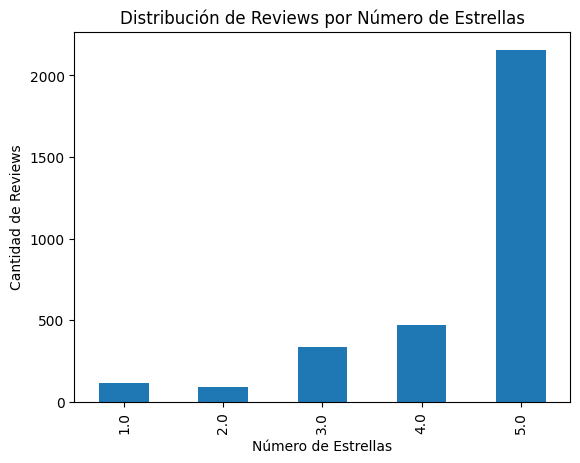

In [8]:
#import matplotlib.pyplot as plt

# Contar reviews por número de estrellas
star_distribution = df['overall'].value_counts().sort_index()

# Visualizar
star_distribution.plot(kind='bar')
plt.xlabel('Número de Estrellas')
plt.ylabel('Cantidad de Reviews')
plt.title('Distribución de Reviews por Número de Estrellas')
plt.show()

## 1.3 - Nº de reviews positivas y negativas

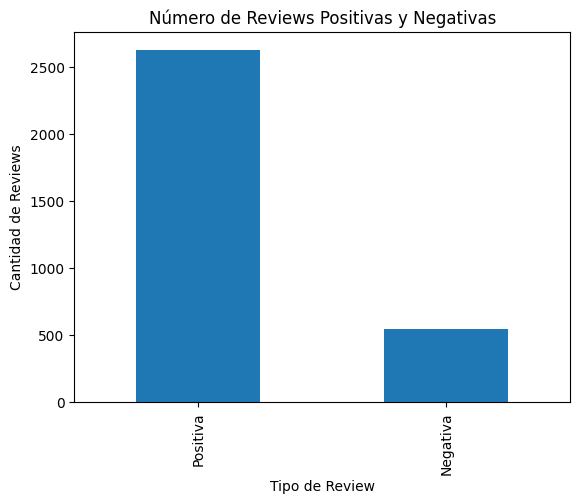

In [9]:
# Definir criterio de clasificación
df['review_type'] = df['overall'].apply(lambda x: 'Positiva' if x >= 4 else 'Negativa')

# Contar reviews positivas y negativas
review_counts = df['review_type'].value_counts()

# Visualizar
review_counts.plot(kind='bar')
plt.xlabel('Tipo de Review')
plt.ylabel('Cantidad de Reviews')
plt.title('Número de Reviews Positivas y Negativas')
plt.show()

Tenemos un claro desbalanceop de clases, veremos que hacer más adelante.

## 1.4 - N-grams más frecuentes

In [10]:
#Sin limpieza de corpus

#from sklearn.feature_extraction.text import CountVectorizer
#from matplotlib import pyplot as plt


def get_top_n_grams(corpus, n=None, ngram_range=(1, 1)):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


corpus = df['reviewText'].dropna().tolist()
top_bigrams = get_top_n_grams(corpus, n=10, ngram_range=(2, 2))# Bigrams más frecuentes

df_bigrams = pd.DataFrame(top_bigrams, columns=['Bigram', 'Frecuencia'])

display(df_bigrams)

,Bigram,Frecuencia
0,these shoes,528
1,they are,492
2,my feet,306
3,very comfortable,297
4,love these,285
5,and they,258
6,on the,249
7,love them,241
8,light weight,221
9,shoes are,184


Se necesita lemmatización, normalización, eliminación de stop-words, stemming. Se podría analizar bigramas por sentimiento positivo o negativo para hacernos una idea.

## 1.5 - Nube de palabras, histograma y tabla de frecuencia

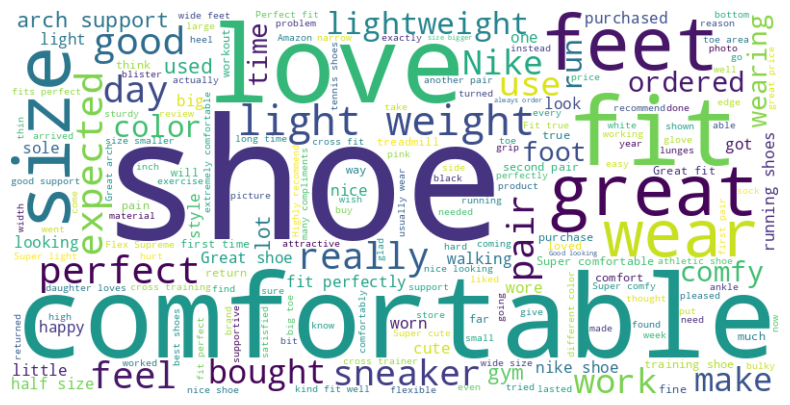

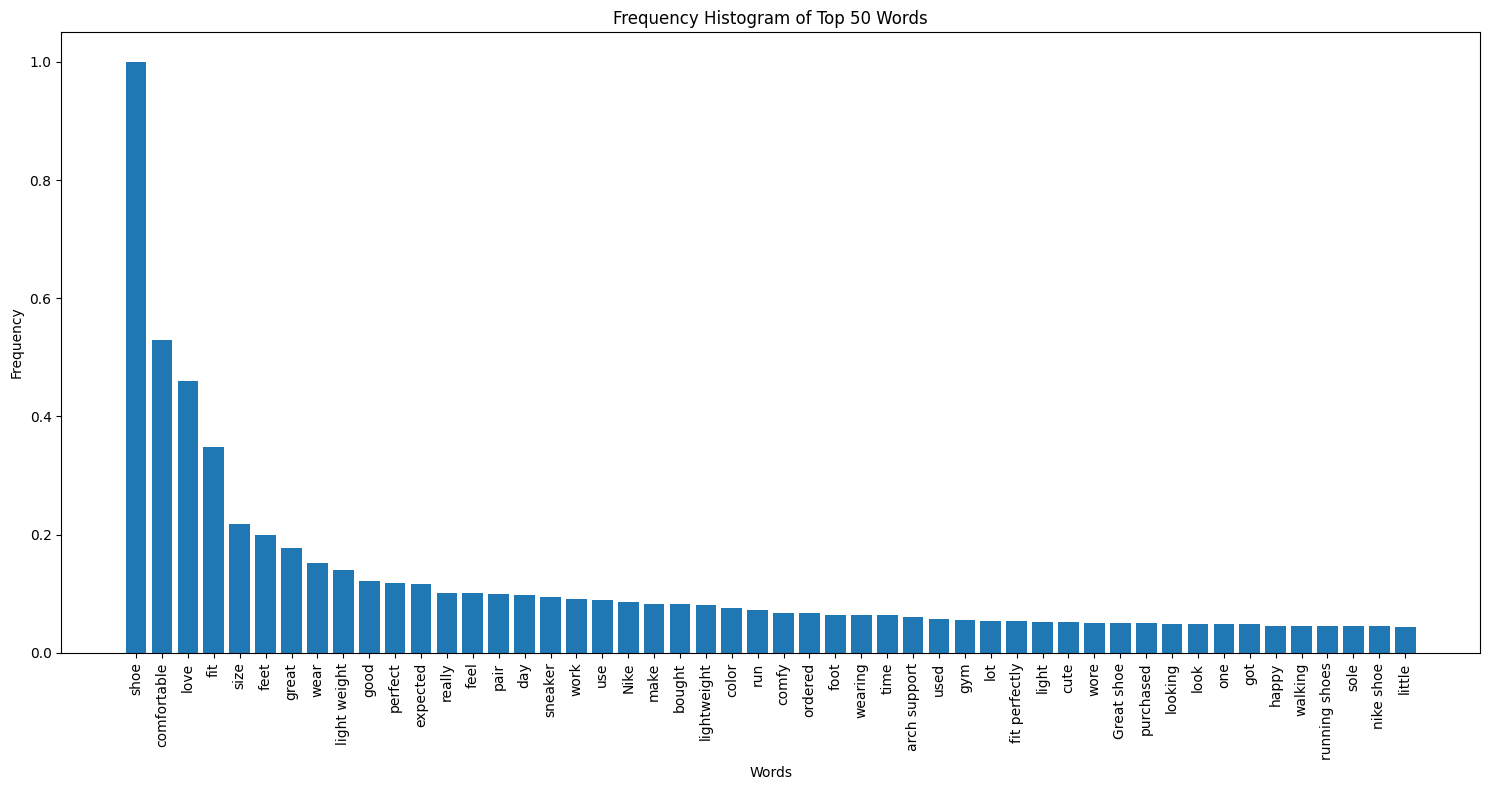

,Word,Frequency
0,shoe,1.000000
1,comfortable,0.529114
2,love,0.460759
3,fit,0.348101
4,size,0.218354
5,feet,0.199367
6,great,0.177848
7,wear,0.152532
8,light weight,0.139873
9,good,0.121519


In [11]:
#from wordcloud import WordCloud

def generate_wordcloud(text_series, top_n=50):
    """
    Generates a word cloud and displays a frequency histogram of the top N words.

    Args:
        text_series (pd.Series): Series of text data.
        top_n (int, optional): Number of top words to display in the histogram. Defaults to 50.
    """
    text = " ".join(text_series.dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Display word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

    # Create and display frequency histogram
    word_freq = wordcloud.words_
    word_freq_df = pd.DataFrame(list(word_freq.items()), columns=['Word', 'Frequency'])
    word_freq_df = word_freq_df.sort_values(by=['Frequency'], ascending=False)  # Sort by frequency

    # Display histogram for top N words
    plt.figure(figsize=(15, 8))  # Adjust figure size as needed
    plt.bar(word_freq_df['Word'][:top_n], word_freq_df['Frequency'][:top_n])
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Frequency Histogram of Top {top_n} Words')
    plt.tight_layout()  # Adjust layout to prevent labels from being cut off
    plt.show()

    # Display frequency table
    display(word_freq_df)



corpus = df['reviewText'].dropna().tolist()
generate_wordcloud(pd.Series(corpus))

## 1.6 - Visualización en 2 dimensiones de word embeddings

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


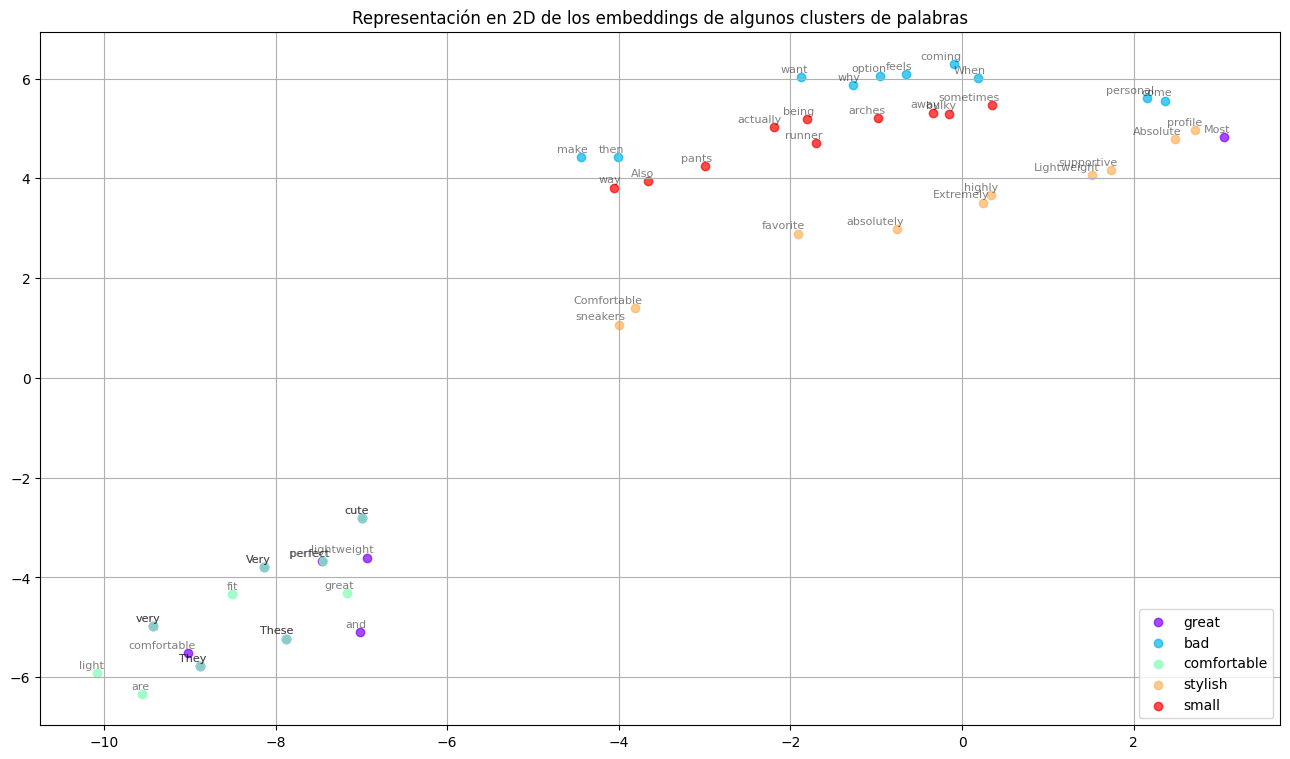

In [12]:
#import numpy as np
#from sklearn.manifold import TSNE

#from gensim.models import Word2Vec
#from gensim.models.word2vec import LineSentence

nltk.download('punkt')
sentences = [nltk.word_tokenize(text) for text in df['reviewText'].dropna()]
model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)
#model.save('w2v_model.pkl') #Podemos guardar el modelo

# Poner 5 palabras
keys = ['great', 'bad', 'comfortable', 'stylish', 'small']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_2d = tsne_model_2d.fit_transform(np.vstack(embedding_clusters))  #Aplicar t-SNE a los embeddings


# Desagrupar embeddings_2d en la estructura original
start = 0
embeddings_2d_list = []
for cluster in word_clusters:
    end = start + len(cluster)
    embeddings_2d_list.append(embeddings_2d[start:end, :])
    start = end

embeddings_2d = embeddings_2d_list  # Reemplazar con la lista desagrupada



import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline


def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.title('Representación en 2D de los embeddings de algunos clusters de palabras')
    # plt.savefig("f/г.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words(keys, embeddings_2d, word_clusters)

## - Más funciones

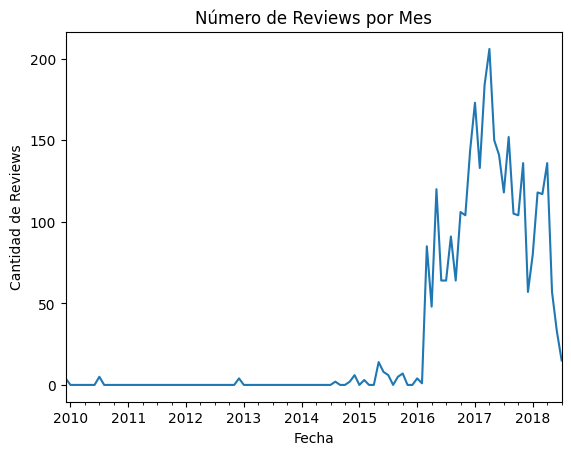

In [13]:
#Serie temporal de reviews

df['reviewTime'] = pd.to_datetime(df['reviewTime'])

# Contar reviews por mes
monthly_reviews = df.set_index('reviewTime').resample('ME').size()

# Visualizar
monthly_reviews.plot(kind='line')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Reviews')
plt.title('Número de Reviews por Mes')
plt.show()

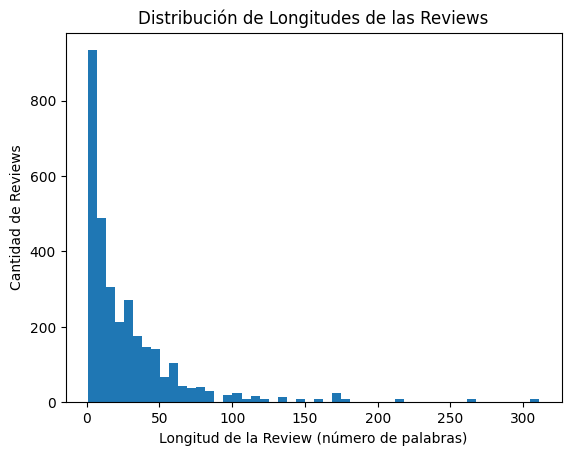

In [14]:
#Distribución de la longitud de las reviews

df['review_length'] = df['reviewText'].dropna().apply(lambda x: len(nltk.word_tokenize(x)))

# Visualizar
df['review_length'].plot(kind='hist', bins=50)
plt.xlabel('Longitud de la Review (número de palabras)')
plt.ylabel('Cantidad de Reviews')
plt.title('Distribución de Longitudes de las Reviews')
plt.show()

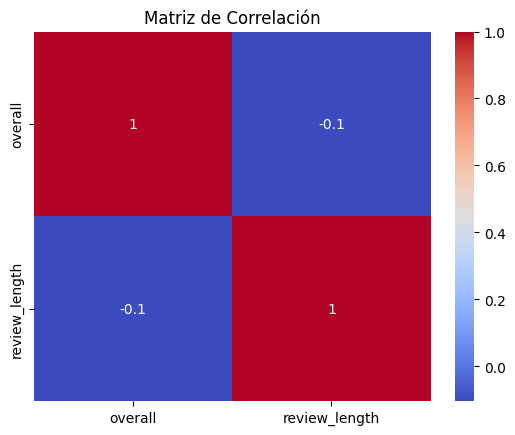

In [15]:
import seaborn as sns

# Calcular correlaciones
correlation_matrix = df[['overall', 'review_length']].corr()

# Visualizar
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

# 2 - Función de limpieza de texto

In [16]:
#import nltk
#import string

# Download necessary NLTK data only once (if not already downloaded)
try:
    nltk.data.find('tokenizers/punkt_tab')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt_tab')
    nltk.download('stopwords')
    nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer

def clean_text(text):
    """
    Limpia el texto de entrada realizando las siguientes operaciones:
    1. Convertir a minúsculas.
    2. Eliminar signos de puntuación.
    3. Eliminar palabras vacías (stop words).
    4. Lematización.

    Args:
        text (str): El texto de entrada que se va a limpiar.

    Returns:
        str: El texto limpio.
    """
    # Lowercasing
    text = text.lower()

    # Removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Removing stop words and lemmatization
    stop_words = set(nltk.corpus.stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    # Joining the cleaned tokens back into a string
    cleaned_text = " ".join(cleaned_tokens)

    return cleaned_text

# Example usage
text = "This is an example sentence with punctuation and stop words!"
cleaned_text = clean_text(text)
print(cleaned_text)  # Output: example sentence punctuation stop word

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


example sentence punctuation stop word


# 3 Y 4 - Modelos (LSTM y LogisticRegression), métricas y análisis

## Modelo LSTM

### Optimización con Optuna de LSTM para análisis de sentimientos

In [17]:
!pip install optuna

In [37]:
#import random
#import numpy as np
#import torch
#import torch.nn as nn
#import torch.optim as optim
#from torch.utils.data import DataLoader, Dataset
#import pandas as pd
#import numpy as np
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, mean_squared_error
#from sklearn.preprocessing import LabelEncoder
#from sklearn.feature_extraction.text import CountVectorizer
#import optuna
#import nltk
#import string
#from nltk.stem import WordNetLemmatizer
#import matplotlib.pyplot as plt
#import seaborn as sns
#from imblearn.over_sampling import SMOTE
#from imblearn.combine import SMOTEENN

# Download necessary NLTK data only once (if not already downloaded)
try:
    nltk.data.find('tokenizers/punkt_tab')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt_tab')
    nltk.download('stopwords')
    nltk.download('wordnet')

random.seed(42)  # Python random number generator
np.random.seed(42)  # NumPy random number generator
torch.manual_seed(42)  # PyTorch random number generator
torch.cuda.manual_seed_all(42)  # PyTorch random number generator for all GPUs


cleaned_corpus_series = df['reviewText'].fillna('').apply(clean_text)#Imputamos valores nulos con ''
cleaned_corpus = cleaned_corpus_series.tolist()

# Separación features and labels
X = cleaned_corpus
y = df['overall'].apply(lambda x: 1 if x >= 4 else 0)

# Filtramos NaN por precaución
valid_indices = df['reviewText'].fillna('').index #Verificamos indices



# Comprobación de índices, evita errores
df_filtered = df.loc[valid_indices]
y_filtered = y.loc[valid_indices]

# 1. Split Train-test
X_train, X_test, y_train, y_test = train_test_split(X, y_filtered, test_size=0.2, random_state=42, stratify=y) # 80% train, 20% test, Uso stratify para mantener las estadisticas en los datos
# 2. Split train en train y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train) # 60% train, 20% validation, 20% test

# Vectorización de la data usando Bag-of-Words
vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train).toarray() # Vectorize training data
X_val_vec = vectorizer.transform(X_val).toarray()       # Vectorize validation data
X_test_vec = vectorizer.transform(X_test).toarray()      # Vectorize test data

# Creación de clase Dataset
class SentimentDataset(Dataset):
    def __init__(self, reviews, labels):
        self.reviews = reviews
        self.labels = labels

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        return torch.tensor(self.reviews[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)  # Changed dtype to long

#Rebalanceo de clases
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_vec, y_train)

# Creación datasets and dataloaders
train_dataset = SentimentDataset(X_train_resampled, y_train_resampled.values) # Use resampled data
val_dataset = SentimentDataset(X_val_vec, y_val.values)
test_dataset = SentimentDataset(X_test_vec, y_test.values)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Definición de la arquitectura de modelo LSTM (2)

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = x.unsqueeze(1)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = torch.relu(out) #RELU antes de la capa lineal
        out = self.fc(out)
        out = torch.sigmoid(out)  # Sigmoid for final output

        return out
# Define the LSTM model architecture 1
#class LSTMModel(nn.Module):
#    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout):
#        super(LSTMModel, self).__init__()
#        self.hidden_dim = hidden_dim
#        self.n_layers = n_layers
#        # Reshape input for LSTM using a linear layer
#        self.embedding = nn.Linear(input_dim, hidden_dim)
#        self.lstm = nn.LSTM(hidden_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
#        self.fc = nn.Linear(hidden_dim, output_dim)
#
#    def forward(self, x):
#        # Reshape input using the embedding layer
#        x = self.embedding(x)
#        # Add a dimension for sequence length (since BoW has no inherent sequence)
#        x = x.unsqueeze(1)  # Now shape is (batch_size, 1, hidden_dim)
#        # Pass through LSTM
#        out, _ = self.lstm(x)
#        # Take the output (out will have shape (batch_size, 1, hidden_dim))
#        out = out[:, -1, :] #Or out = out.squeeze(1) to remove the sequence dimension
#        # Pass through fully connected layer
#        out = self.fc(out)
#        out = torch.sigmoid(out)
#        return out

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def objective(trial):
    # Define el número de unidades ocultas en la capa LSTM, explorando valores entre 32 y 128
    hidden_dim = trial.suggest_int('hidden_dim', 32, 128)
    # Especifica el número de capas de la red LSTM, probando entre 1 y 3 capas
    n_layers = trial.suggest_int('n_layers', 1, 3)
    # Configura la tasa de dropout para evitar sobreajuste, explorando valores entre 0.1 y 0.5
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)

    model = LSTMModel(input_dim=X_train_vec.shape[1],
                      hidden_dim=hidden_dim,
                      output_dim=1,
                      n_layers=n_layers,
                      dropout=dropout).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    early_stopping_patience = 5  # Establece el número de épocas sin mejora antes de activar el early stopping
    best_val_loss = np.inf
    best_val_accuracy = 0.0
    epochs_without_improvement = 0

    for epoch in range(10):
        train_loss = 0
        model.train()
        for reviews, labels in train_loader:
            reviews, labels = reviews.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(reviews)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * reviews.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0
        val_preds = []
        with torch.no_grad():
            for reviews, labels in val_loader:
                reviews, labels = reviews.to(device), labels.to(device)
                outputs = model(reviews)
                loss = criterion(outputs.squeeze(), labels.float())
                val_loss += loss.item() * reviews.size(0)
                preds = (outputs.squeeze() > 0.5).float()
                val_preds.extend(preds.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        # Calcula la precisión del modelo en el conjunto de validación
        val_accuracy = accuracy_score(y_val, val_preds)
        # Define la función objetivo combinada, ponderando más la pérdida de validación que la precisión
        combined_objective = 0.8 * val_loss - 0.2 * val_accuracy

        #Verifica si el modelo actual mejora el mejor modelo registrado basado en el objetivo combinado.
        if combined_objective < (0.8 * best_val_loss - 0.2 * best_val_accuracy):
            best_val_loss = val_loss
            best_val_accuracy = val_accuracy
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        print(f"Epoch {epoch + 1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f} | Combined Objective: {combined_objective:.4f}")  # Imprime métricas de la época actual para el seguimiento del entrenamiento

    return combined_objective

# Creación del estudio para los mejores hiperparámetros
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Mejores hiperparámetros
print(f"Mejores hiperparámetros: {study.best_params}")





[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[I 2025-02-13 12:05:46,863] A new study created in memory with name: no-name-76662ccc-7277-475a-8425-df8e3407acec


Epoch 1 | Train Loss: 0.4464 | Val Loss: 0.2451 | Val Accuracy: 0.9087 | Combined Objective: 0.0143
Epoch 2 | Train Loss: 0.0465 | Val Loss: 0.2541 | Val Accuracy: 0.9213 | Combined Objective: 0.0190
Epoch 3 | Train Loss: 0.0253 | Val Loss: 0.2488 | Val Accuracy: 0.9291 | Combined Objective: 0.0132
Epoch 4 | Train Loss: 0.0159 | Val Loss: 0.2773 | Val Accuracy: 0.9213 | Combined Objective: 0.0376
Epoch 5 | Train Loss: 0.0110 | Val Loss: 0.2887 | Val Accuracy: 0.9244 | Combined Objective: 0.0461
Epoch 6 | Train Loss: 0.0087 | Val Loss: 0.3238 | Val Accuracy: 0.9197 | Combined Objective: 0.0751
Epoch 7 | Train Loss: 0.0079 | Val Loss: 0.3205 | Val Accuracy: 0.9165 | Combined Objective: 0.0731


[I 2025-02-13 12:05:53,972] Trial 0 finished with value: 0.08897970063274535 and parameters: {'hidden_dim': 51, 'n_layers': 2, 'dropout': 0.3851411208443295, 'learning_rate': 0.0017694804579761554, 'weight_decay': 0.000808494271183117}. Best is trial 0 with value: 0.08897970063274535.


Early stopping at epoch 8
Epoch 1 | Train Loss: 0.2455 | Val Loss: 0.2010 | Val Accuracy: 0.9386 | Combined Objective: -0.0269
Epoch 2 | Train Loss: 0.0104 | Val Loss: 0.2540 | Val Accuracy: 0.9465 | Combined Objective: 0.0139
Epoch 3 | Train Loss: 0.0029 | Val Loss: 0.3026 | Val Accuracy: 0.9417 | Combined Objective: 0.0537
Epoch 4 | Train Loss: 0.0018 | Val Loss: 0.3558 | Val Accuracy: 0.9260 | Combined Objective: 0.0994
Epoch 5 | Train Loss: 0.0014 | Val Loss: 0.3648 | Val Accuracy: 0.9260 | Combined Objective: 0.1066


[I 2025-02-13 12:06:00,439] Trial 1 finished with value: 0.12419178400460015 and parameters: {'hidden_dim': 86, 'n_layers': 1, 'dropout': 0.20596886338695405, 'learning_rate': 0.002136126489187029, 'weight_decay': 3.9932515422365185e-05}. Best is trial 0 with value: 0.08897970063274535.


Early stopping at epoch 6
Epoch 1 | Train Loss: 0.5547 | Val Loss: 0.2833 | Val Accuracy: 0.9402 | Combined Objective: 0.0386
Epoch 2 | Train Loss: 0.1411 | Val Loss: 0.1789 | Val Accuracy: 0.9291 | Combined Objective: -0.0427
Epoch 3 | Train Loss: 0.0610 | Val Loss: 0.1792 | Val Accuracy: 0.9260 | Combined Objective: -0.0418
Epoch 4 | Train Loss: 0.0358 | Val Loss: 0.1905 | Val Accuracy: 0.9370 | Combined Objective: -0.0350
Epoch 5 | Train Loss: 0.0237 | Val Loss: 0.2202 | Val Accuracy: 0.9276 | Combined Objective: -0.0094
Epoch 6 | Train Loss: 0.0178 | Val Loss: 0.2324 | Val Accuracy: 0.9244 | Combined Objective: 0.0010


[I 2025-02-13 12:06:09,099] Trial 2 finished with value: 0.01670578312744775 and parameters: {'hidden_dim': 125, 'n_layers': 1, 'dropout': 0.45229770128804747, 'learning_rate': 0.00045525521821314, 'weight_decay': 0.0003651467759017323}. Best is trial 2 with value: 0.01670578312744775.


Early stopping at epoch 7
Epoch 1 | Train Loss: 0.6536 | Val Loss: 0.5231 | Val Accuracy: 0.9591 | Combined Objective: 0.2267
Epoch 2 | Train Loss: 0.3559 | Val Loss: 0.2074 | Val Accuracy: 0.9496 | Combined Objective: -0.0240
Epoch 3 | Train Loss: 0.1611 | Val Loss: 0.1619 | Val Accuracy: 0.9307 | Combined Objective: -0.0566
Epoch 4 | Train Loss: 0.0953 | Val Loss: 0.1567 | Val Accuracy: 0.9370 | Combined Objective: -0.0621
Epoch 5 | Train Loss: 0.0638 | Val Loss: 0.1638 | Val Accuracy: 0.9386 | Combined Objective: -0.0567
Epoch 6 | Train Loss: 0.0444 | Val Loss: 0.1747 | Val Accuracy: 0.9449 | Combined Objective: -0.0492
Epoch 7 | Train Loss: 0.0315 | Val Loss: 0.1816 | Val Accuracy: 0.9465 | Combined Objective: -0.0441
Epoch 8 | Train Loss: 0.0243 | Val Loss: 0.1914 | Val Accuracy: 0.9402 | Combined Objective: -0.0349


[I 2025-02-13 12:06:17,314] Trial 3 finished with value: -0.023479790882332124 and parameters: {'hidden_dim': 68, 'n_layers': 1, 'dropout': 0.44693241313004506, 'learning_rate': 0.0003456576518710678, 'weight_decay': 6.186726938113503e-05}. Best is trial 3 with value: -0.023479790882332124.


Early stopping at epoch 9
Epoch 1 | Train Loss: 0.1290 | Val Loss: 0.3065 | Val Accuracy: 0.9291 | Combined Objective: 0.0594
Epoch 2 | Train Loss: 0.0303 | Val Loss: 0.3874 | Val Accuracy: 0.9291 | Combined Objective: 0.1241
Epoch 3 | Train Loss: 0.0149 | Val Loss: 0.4034 | Val Accuracy: 0.9276 | Combined Objective: 0.1372
Epoch 4 | Train Loss: 0.0026 | Val Loss: 0.4072 | Val Accuracy: 0.9307 | Combined Objective: 0.1396
Epoch 5 | Train Loss: 0.0084 | Val Loss: 0.4106 | Val Accuracy: 0.9244 | Combined Objective: 0.1436


[I 2025-02-13 12:06:24,642] Trial 4 finished with value: 0.10198281619199148 and parameters: {'hidden_dim': 120, 'n_layers': 1, 'dropout': 0.4051247152405053, 'learning_rate': 0.007008955225324079, 'weight_decay': 0.00016908785788493966}. Best is trial 3 with value: -0.023479790882332124.


Early stopping at epoch 6
Epoch 1 | Train Loss: 0.6794 | Val Loss: 0.6466 | Val Accuracy: 0.9433 | Combined Objective: 0.3286
Epoch 2 | Train Loss: 0.5743 | Val Loss: 0.5128 | Val Accuracy: 0.9449 | Combined Objective: 0.2212
Epoch 3 | Train Loss: 0.3912 | Val Loss: 0.3303 | Val Accuracy: 0.9433 | Combined Objective: 0.0755
Epoch 4 | Train Loss: 0.2595 | Val Loss: 0.2386 | Val Accuracy: 0.9433 | Combined Objective: 0.0022
Epoch 5 | Train Loss: 0.1883 | Val Loss: 0.2004 | Val Accuracy: 0.9433 | Combined Objective: -0.0284
Epoch 6 | Train Loss: 0.1452 | Val Loss: 0.1800 | Val Accuracy: 0.9354 | Combined Objective: -0.0431
Epoch 7 | Train Loss: 0.1156 | Val Loss: 0.1743 | Val Accuracy: 0.9307 | Combined Objective: -0.0467
Epoch 8 | Train Loss: 0.0938 | Val Loss: 0.1677 | Val Accuracy: 0.9370 | Combined Objective: -0.0533
Epoch 9 | Train Loss: 0.0771 | Val Loss: 0.1654 | Val Accuracy: 0.9386 | Combined Objective: -0.0554


[I 2025-02-13 12:06:32,845] Trial 5 finished with value: -0.05409324885353328 and parameters: {'hidden_dim': 62, 'n_layers': 1, 'dropout': 0.19190341895655513, 'learning_rate': 0.00015203140008226954, 'weight_decay': 1.3942502457716736e-05}. Best is trial 5 with value: -0.05409324885353328.


Epoch 10 | Train Loss: 0.0637 | Val Loss: 0.1686 | Val Accuracy: 0.9449 | Combined Objective: -0.0541
Epoch 1 | Train Loss: 0.2243 | Val Loss: 0.2523 | Val Accuracy: 0.9165 | Combined Objective: 0.0185
Epoch 2 | Train Loss: 0.0183 | Val Loss: 0.3419 | Val Accuracy: 0.9150 | Combined Objective: 0.0906
Epoch 3 | Train Loss: 0.0078 | Val Loss: 0.2976 | Val Accuracy: 0.9181 | Combined Objective: 0.0545
Epoch 4 | Train Loss: 0.0055 | Val Loss: 0.3646 | Val Accuracy: 0.9197 | Combined Objective: 0.1077
Epoch 5 | Train Loss: 0.0054 | Val Loss: 0.4241 | Val Accuracy: 0.9197 | Combined Objective: 0.1553


[I 2025-02-13 12:06:40,971] Trial 6 finished with value: 0.21292498987872066 and parameters: {'hidden_dim': 126, 'n_layers': 1, 'dropout': 0.13571881814229958, 'learning_rate': 0.0020043953950521984, 'weight_decay': 0.00038574555182378307}. Best is trial 5 with value: -0.05409324885353328.


Early stopping at epoch 6
Epoch 1 | Train Loss: 0.6283 | Val Loss: 0.5362 | Val Accuracy: 0.8394 | Combined Objective: 0.2611
Epoch 2 | Train Loss: 0.1752 | Val Loss: 0.2308 | Val Accuracy: 0.9134 | Combined Objective: 0.0020
Epoch 3 | Train Loss: 0.0437 | Val Loss: 0.2478 | Val Accuracy: 0.9244 | Combined Objective: 0.0134
Epoch 4 | Train Loss: 0.0235 | Val Loss: 0.2883 | Val Accuracy: 0.9228 | Combined Objective: 0.0461
Epoch 5 | Train Loss: 0.0173 | Val Loss: 0.2640 | Val Accuracy: 0.9228 | Combined Objective: 0.0266
Epoch 6 | Train Loss: 0.0139 | Val Loss: 0.2930 | Val Accuracy: 0.9228 | Combined Objective: 0.0498


[I 2025-02-13 12:06:48,006] Trial 7 finished with value: 0.05226117326049354 and parameters: {'hidden_dim': 70, 'n_layers': 2, 'dropout': 0.3807338640775323, 'learning_rate': 0.0006679256959139491, 'weight_decay': 0.0005945398183336493}. Best is trial 5 with value: -0.05409324885353328.


Early stopping at epoch 7
Epoch 1 | Train Loss: 0.5729 | Val Loss: 0.3181 | Val Accuracy: 0.9654 | Combined Objective: 0.0614
Epoch 2 | Train Loss: 0.1883 | Val Loss: 0.1623 | Val Accuracy: 0.9307 | Combined Objective: -0.0563
Epoch 3 | Train Loss: 0.0802 | Val Loss: 0.1589 | Val Accuracy: 0.9339 | Combined Objective: -0.0597
Epoch 4 | Train Loss: 0.0445 | Val Loss: 0.1759 | Val Accuracy: 0.9433 | Combined Objective: -0.0480
Epoch 5 | Train Loss: 0.0280 | Val Loss: 0.1872 | Val Accuracy: 0.9433 | Combined Objective: -0.0389
Epoch 6 | Train Loss: 0.0189 | Val Loss: 0.2121 | Val Accuracy: 0.9354 | Combined Objective: -0.0174
Epoch 7 | Train Loss: 0.0138 | Val Loss: 0.2348 | Val Accuracy: 0.9323 | Combined Objective: 0.0014


[I 2025-02-13 12:06:55,859] Trial 8 finished with value: 0.009098441940475627 and parameters: {'hidden_dim': 75, 'n_layers': 1, 'dropout': 0.32836909018936344, 'learning_rate': 0.000489594352871349, 'weight_decay': 0.00019163462406191167}. Best is trial 5 with value: -0.05409324885353328.


Early stopping at epoch 8
Epoch 1 | Train Loss: 0.6913 | Val Loss: 0.7179 | Val Accuracy: 0.1717 | Combined Objective: 0.5400
Epoch 2 | Train Loss: 0.6127 | Val Loss: 0.6179 | Val Accuracy: 0.8094 | Combined Objective: 0.3324
Epoch 3 | Train Loss: 0.3857 | Val Loss: 0.4542 | Val Accuracy: 0.8929 | Combined Objective: 0.1848
Epoch 4 | Train Loss: 0.2076 | Val Loss: 0.3125 | Val Accuracy: 0.9024 | Combined Objective: 0.0695
Epoch 5 | Train Loss: 0.1117 | Val Loss: 0.2463 | Val Accuracy: 0.9181 | Combined Objective: 0.0135
Epoch 6 | Train Loss: 0.0688 | Val Loss: 0.2243 | Val Accuracy: 0.9323 | Combined Objective: -0.0070
Epoch 7 | Train Loss: 0.0474 | Val Loss: 0.2234 | Val Accuracy: 0.9402 | Combined Objective: -0.0093
Epoch 8 | Train Loss: 0.0347 | Val Loss: 0.2288 | Val Accuracy: 0.9433 | Combined Objective: -0.0056
Epoch 9 | Train Loss: 0.0271 | Val Loss: 0.2364 | Val Accuracy: 0.9433 | Combined Objective: 0.0005


[I 2025-02-13 12:07:08,633] Trial 9 finished with value: 0.006814427352327068 and parameters: {'hidden_dim': 75, 'n_layers': 3, 'dropout': 0.4633206843555263, 'learning_rate': 0.000167947344464701, 'weight_decay': 2.0770397529199902e-05}. Best is trial 5 with value: -0.05409324885353328.


Epoch 10 | Train Loss: 0.0220 | Val Loss: 0.2443 | Val Accuracy: 0.9433 | Combined Objective: 0.0068
Epoch 1 | Train Loss: 0.6927 | Val Loss: 0.7031 | Val Accuracy: 0.1717 | Combined Objective: 0.5281
Epoch 2 | Train Loss: 0.6919 | Val Loss: 0.7023 | Val Accuracy: 0.1717 | Combined Objective: 0.5275
Epoch 3 | Train Loss: 0.6870 | Val Loss: 0.6950 | Val Accuracy: 0.1969 | Combined Objective: 0.5166
Epoch 4 | Train Loss: 0.6682 | Val Loss: 0.6742 | Val Accuracy: 0.7606 | Combined Objective: 0.3873
Epoch 5 | Train Loss: 0.6189 | Val Loss: 0.6378 | Val Accuracy: 0.8630 | Combined Objective: 0.3376
Epoch 6 | Train Loss: 0.5532 | Val Loss: 0.5943 | Val Accuracy: 0.8677 | Combined Objective: 0.3019
Epoch 7 | Train Loss: 0.4858 | Val Loss: 0.5399 | Val Accuracy: 0.8929 | Combined Objective: 0.2533
Epoch 8 | Train Loss: 0.4215 | Val Loss: 0.4840 | Val Accuracy: 0.8929 | Combined Objective: 0.2086
Epoch 9 | Train Loss: 0.3627 | Val Loss: 0.4324 | Val Accuracy: 0.9008 | Combined Objective: 0.1658

[I 2025-02-13 12:07:17,164] Trial 10 finished with value: 0.13224980868692476 and parameters: {'hidden_dim': 32, 'n_layers': 3, 'dropout': 0.2395697776411304, 'learning_rate': 0.00010039946328561348, 'weight_decay': 1.1522383016165565e-05}. Best is trial 5 with value: -0.05409324885353328.


Epoch 10 | Train Loss: 0.3121 | Val Loss: 0.3909 | Val Accuracy: 0.9024 | Combined Objective: 0.1322
Epoch 1 | Train Loss: 0.6653 | Val Loss: 0.6346 | Val Accuracy: 0.8220 | Combined Objective: 0.3432
Epoch 2 | Train Loss: 0.4007 | Val Loss: 0.3804 | Val Accuracy: 0.8929 | Combined Objective: 0.1257
Epoch 3 | Train Loss: 0.1540 | Val Loss: 0.2473 | Val Accuracy: 0.9024 | Combined Objective: 0.0174
Epoch 4 | Train Loss: 0.0680 | Val Loss: 0.2563 | Val Accuracy: 0.9181 | Combined Objective: 0.0214
Epoch 5 | Train Loss: 0.0367 | Val Loss: 0.2768 | Val Accuracy: 0.9165 | Combined Objective: 0.0381
Epoch 6 | Train Loss: 0.0228 | Val Loss: 0.2937 | Val Accuracy: 0.9150 | Combined Objective: 0.0520
Epoch 7 | Train Loss: 0.0155 | Val Loss: 0.3129 | Val Accuracy: 0.9197 | Combined Objective: 0.0663


[I 2025-02-13 12:07:27,299] Trial 11 finished with value: 0.08039948208418887 and parameters: {'hidden_dim': 98, 'n_layers': 2, 'dropout': 0.11269684333579649, 'learning_rate': 0.00023580543699767116, 'weight_decay': 5.4546557520554885e-05}. Best is trial 5 with value: -0.05409324885353328.


Early stopping at epoch 8
Epoch 1 | Train Loss: 0.6669 | Val Loss: 0.6490 | Val Accuracy: 0.6472 | Combined Objective: 0.3897
Epoch 2 | Train Loss: 0.4730 | Val Loss: 0.3747 | Val Accuracy: 0.9291 | Combined Objective: 0.1139
Epoch 3 | Train Loss: 0.2607 | Val Loss: 0.2430 | Val Accuracy: 0.9307 | Combined Objective: 0.0082
Epoch 4 | Train Loss: 0.1672 | Val Loss: 0.2064 | Val Accuracy: 0.9181 | Combined Objective: -0.0185
Epoch 5 | Train Loss: 0.1189 | Val Loss: 0.1888 | Val Accuracy: 0.9228 | Combined Objective: -0.0335
Epoch 6 | Train Loss: 0.0876 | Val Loss: 0.1858 | Val Accuracy: 0.9213 | Combined Objective: -0.0356
Epoch 7 | Train Loss: 0.0666 | Val Loss: 0.1876 | Val Accuracy: 0.9213 | Combined Objective: -0.0342
Epoch 8 | Train Loss: 0.0514 | Val Loss: 0.1885 | Val Accuracy: 0.9307 | Combined Objective: -0.0354
Epoch 9 | Train Loss: 0.0401 | Val Loss: 0.1918 | Val Accuracy: 0.9386 | Combined Objective: -0.0343


[I 2025-02-13 12:07:35,538] Trial 12 finished with value: -0.027997506108340314 and parameters: {'hidden_dim': 55, 'n_layers': 1, 'dropout': 0.24994299457473046, 'learning_rate': 0.00024195884823070772, 'weight_decay': 6.426233636217106e-05}. Best is trial 5 with value: -0.05409324885353328.


Epoch 10 | Train Loss: 0.0321 | Val Loss: 0.1996 | Val Accuracy: 0.9386 | Combined Objective: -0.0280
Epoch 1 | Train Loss: 0.6921 | Val Loss: 0.6875 | Val Accuracy: 0.9102 | Combined Objective: 0.3679
Epoch 2 | Train Loss: 0.6694 | Val Loss: 0.6643 | Val Accuracy: 0.8362 | Combined Objective: 0.3642
Epoch 3 | Train Loss: 0.5747 | Val Loss: 0.6002 | Val Accuracy: 0.8331 | Combined Objective: 0.3135
Epoch 4 | Train Loss: 0.4499 | Val Loss: 0.5035 | Val Accuracy: 0.8709 | Combined Objective: 0.2286
Epoch 5 | Train Loss: 0.3307 | Val Loss: 0.3819 | Val Accuracy: 0.8961 | Combined Objective: 0.1263
Epoch 6 | Train Loss: 0.2314 | Val Loss: 0.3036 | Val Accuracy: 0.9008 | Combined Objective: 0.0627
Epoch 7 | Train Loss: 0.1686 | Val Loss: 0.2665 | Val Accuracy: 0.9008 | Combined Objective: 0.0330
Epoch 8 | Train Loss: 0.1282 | Val Loss: 0.2519 | Val Accuracy: 0.9024 | Combined Objective: 0.0211
Epoch 9 | Train Loss: 0.1004 | Val Loss: 0.2473 | Val Accuracy: 0.9071 | Combined Objective: 0.016

[I 2025-02-13 12:07:45,156] Trial 13 finished with value: 0.011270840426129608 and parameters: {'hidden_dim': 52, 'n_layers': 2, 'dropout': 0.2320766765708694, 'learning_rate': 0.00011996540115263746, 'weight_decay': 2.2286287647787394e-05}. Best is trial 5 with value: -0.05409324885353328.


Epoch 10 | Train Loss: 0.0809 | Val Loss: 0.2432 | Val Accuracy: 0.9165 | Combined Objective: 0.0113
Epoch 1 | Train Loss: 0.6700 | Val Loss: 0.6393 | Val Accuracy: 0.9433 | Combined Objective: 0.3228
Epoch 2 | Train Loss: 0.5056 | Val Loss: 0.4371 | Val Accuracy: 0.9244 | Combined Objective: 0.1648
Epoch 3 | Train Loss: 0.3001 | Val Loss: 0.2757 | Val Accuracy: 0.9354 | Combined Objective: 0.0334
Epoch 4 | Train Loss: 0.1914 | Val Loss: 0.2194 | Val Accuracy: 0.9307 | Combined Objective: -0.0106
Epoch 5 | Train Loss: 0.1363 | Val Loss: 0.1999 | Val Accuracy: 0.9307 | Combined Objective: -0.0262
Epoch 6 | Train Loss: 0.1028 | Val Loss: 0.1901 | Val Accuracy: 0.9307 | Combined Objective: -0.0341
Epoch 7 | Train Loss: 0.0790 | Val Loss: 0.1886 | Val Accuracy: 0.9260 | Combined Objective: -0.0343
Epoch 8 | Train Loss: 0.0622 | Val Loss: 0.1885 | Val Accuracy: 0.9307 | Combined Objective: -0.0353
Epoch 9 | Train Loss: 0.0489 | Val Loss: 0.1946 | Val Accuracy: 0.9323 | Combined Objective: -

[I 2025-02-13 12:07:52,766] Trial 14 finished with value: -0.028080153052262413 and parameters: {'hidden_dim': 52, 'n_layers': 1, 'dropout': 0.2825626540577962, 'learning_rate': 0.00023199770514159703, 'weight_decay': 1.0234226481802763e-05}. Best is trial 5 with value: -0.05409324885353328.


Epoch 10 | Train Loss: 0.0395 | Val Loss: 0.1995 | Val Accuracy: 0.9386 | Combined Objective: -0.0281
Epoch 1 | Train Loss: 0.6158 | Val Loss: 0.4277 | Val Accuracy: 0.9165 | Combined Objective: 0.1589
Epoch 2 | Train Loss: 0.1985 | Val Loss: 0.1951 | Val Accuracy: 0.9307 | Combined Objective: -0.0301
Epoch 3 | Train Loss: 0.0614 | Val Loss: 0.2176 | Val Accuracy: 0.9276 | Combined Objective: -0.0114
Epoch 4 | Train Loss: 0.0329 | Val Loss: 0.2070 | Val Accuracy: 0.9417 | Combined Objective: -0.0227
Epoch 5 | Train Loss: 0.0212 | Val Loss: 0.2215 | Val Accuracy: 0.9417 | Combined Objective: -0.0112
Epoch 6 | Train Loss: 0.0152 | Val Loss: 0.2414 | Val Accuracy: 0.9417 | Combined Objective: 0.0047


[I 2025-02-13 12:07:58,890] Trial 15 finished with value: 0.013975388387174159 and parameters: {'hidden_dim': 33, 'n_layers': 2, 'dropout': 0.17501618304698385, 'learning_rate': 0.0009142051027291649, 'weight_decay': 1.0496376258380334e-05}. Best is trial 5 with value: -0.05409324885353328.


Early stopping at epoch 7
Epoch 1 | Train Loss: 0.6637 | Val Loss: 0.6494 | Val Accuracy: 0.6409 | Combined Objective: 0.3914
Epoch 2 | Train Loss: 0.4337 | Val Loss: 0.3394 | Val Accuracy: 0.9244 | Combined Objective: 0.0867
Epoch 3 | Train Loss: 0.2167 | Val Loss: 0.2235 | Val Accuracy: 0.9213 | Combined Objective: -0.0054
Epoch 4 | Train Loss: 0.1347 | Val Loss: 0.1969 | Val Accuracy: 0.9213 | Combined Objective: -0.0267
Epoch 5 | Train Loss: 0.0928 | Val Loss: 0.1882 | Val Accuracy: 0.9213 | Combined Objective: -0.0337
Epoch 6 | Train Loss: 0.0659 | Val Loss: 0.1931 | Val Accuracy: 0.9213 | Combined Objective: -0.0298
Epoch 7 | Train Loss: 0.0483 | Val Loss: 0.2013 | Val Accuracy: 0.9260 | Combined Objective: -0.0242
Epoch 8 | Train Loss: 0.0361 | Val Loss: 0.2066 | Val Accuracy: 0.9323 | Combined Objective: -0.0212
Epoch 9 | Train Loss: 0.0272 | Val Loss: 0.2149 | Val Accuracy: 0.9339 | Combined Objective: -0.0148


[I 2025-02-13 12:08:10,513] Trial 16 finished with value: -0.0067383647962348525 and parameters: {'hidden_dim': 92, 'n_layers': 1, 'dropout': 0.3049278408116309, 'learning_rate': 0.00020498378000331029, 'weight_decay': 2.0564356909624334e-05}. Best is trial 5 with value: -0.05409324885353328.


Early stopping at epoch 10
Epoch 1 | Train Loss: 0.2517 | Val Loss: 0.2941 | Val Accuracy: 0.9339 | Combined Objective: 0.0485
Epoch 2 | Train Loss: 0.0144 | Val Loss: 0.4221 | Val Accuracy: 0.9197 | Combined Objective: 0.1538
Epoch 3 | Train Loss: 0.0246 | Val Loss: 0.4037 | Val Accuracy: 0.9276 | Combined Objective: 0.1374
Epoch 4 | Train Loss: 0.0163 | Val Loss: 0.3796 | Val Accuracy: 0.9307 | Combined Objective: 0.1175
Epoch 5 | Train Loss: 0.0050 | Val Loss: 0.3869 | Val Accuracy: 0.9323 | Combined Objective: 0.1231


[I 2025-02-13 12:08:16,026] Trial 17 finished with value: 0.12942305530912768 and parameters: {'hidden_dim': 44, 'n_layers': 3, 'dropout': 0.2763164208253006, 'learning_rate': 0.005673290125923161, 'weight_decay': 2.9925442637922174e-05}. Best is trial 5 with value: -0.05409324885353328.


Early stopping at epoch 6
Epoch 1 | Train Loss: 0.6666 | Val Loss: 0.6075 | Val Accuracy: 0.8835 | Combined Objective: 0.3093
Epoch 2 | Train Loss: 0.3734 | Val Loss: 0.2413 | Val Accuracy: 0.9276 | Combined Objective: 0.0075
Epoch 3 | Train Loss: 0.1427 | Val Loss: 0.1839 | Val Accuracy: 0.9276 | Combined Objective: -0.0384
Epoch 4 | Train Loss: 0.0709 | Val Loss: 0.1926 | Val Accuracy: 0.9386 | Combined Objective: -0.0336
Epoch 5 | Train Loss: 0.0395 | Val Loss: 0.2132 | Val Accuracy: 0.9386 | Combined Objective: -0.0172
Epoch 6 | Train Loss: 0.0252 | Val Loss: 0.2303 | Val Accuracy: 0.9386 | Combined Objective: -0.0035
Epoch 7 | Train Loss: 0.0175 | Val Loss: 0.2488 | Val Accuracy: 0.9386 | Combined Objective: 0.0113


[I 2025-02-13 12:08:24,029] Trial 18 finished with value: 0.020289422229049725 and parameters: {'hidden_dim': 60, 'n_layers': 2, 'dropout': 0.1702355588619044, 'learning_rate': 0.00033045969743558304, 'weight_decay': 1.4889049839017742e-05}. Best is trial 5 with value: -0.05409324885353328.


Early stopping at epoch 8
Epoch 1 | Train Loss: 0.6767 | Val Loss: 0.6508 | Val Accuracy: 0.9496 | Combined Objective: 0.3307
Epoch 2 | Train Loss: 0.5348 | Val Loss: 0.4363 | Val Accuracy: 0.9354 | Combined Objective: 0.1620
Epoch 3 | Train Loss: 0.3064 | Val Loss: 0.2519 | Val Accuracy: 0.9433 | Combined Objective: 0.0129
Epoch 4 | Train Loss: 0.1885 | Val Loss: 0.1936 | Val Accuracy: 0.9417 | Combined Objective: -0.0335
Epoch 5 | Train Loss: 0.1348 | Val Loss: 0.1741 | Val Accuracy: 0.9307 | Combined Objective: -0.0469
Epoch 6 | Train Loss: 0.1023 | Val Loss: 0.1698 | Val Accuracy: 0.9307 | Combined Objective: -0.0503
Epoch 7 | Train Loss: 0.0795 | Val Loss: 0.1700 | Val Accuracy: 0.9339 | Combined Objective: -0.0508
Epoch 8 | Train Loss: 0.0630 | Val Loss: 0.1740 | Val Accuracy: 0.9307 | Combined Objective: -0.0469
Epoch 9 | Train Loss: 0.0510 | Val Loss: 0.1746 | Val Accuracy: 0.9354 | Combined Objective: -0.0474


[I 2025-02-13 12:08:35,532] Trial 19 finished with value: -0.043255806567631366 and parameters: {'hidden_dim': 106, 'n_layers': 1, 'dropout': 0.3328884165323778, 'learning_rate': 0.00014019884454595624, 'weight_decay': 0.00012277628358298175}. Best is trial 5 with value: -0.05409324885353328.


Epoch 10 | Train Loss: 0.0411 | Val Loss: 0.1814 | Val Accuracy: 0.9417 | Combined Objective: -0.0433
Epoch 1 | Train Loss: 0.6888 | Val Loss: 0.7038 | Val Accuracy: 0.1764 | Combined Objective: 0.5277
Epoch 2 | Train Loss: 0.6040 | Val Loss: 0.6156 | Val Accuracy: 0.7984 | Combined Objective: 0.3328
Epoch 3 | Train Loss: 0.3920 | Val Loss: 0.4273 | Val Accuracy: 0.8772 | Combined Objective: 0.1664
Epoch 4 | Train Loss: 0.2177 | Val Loss: 0.2755 | Val Accuracy: 0.9055 | Combined Objective: 0.0393
Epoch 5 | Train Loss: 0.1254 | Val Loss: 0.2269 | Val Accuracy: 0.9181 | Combined Objective: -0.0021
Epoch 6 | Train Loss: 0.0829 | Val Loss: 0.2281 | Val Accuracy: 0.9134 | Combined Objective: -0.0002
Epoch 7 | Train Loss: 0.0592 | Val Loss: 0.2320 | Val Accuracy: 0.9244 | Combined Objective: 0.0007
Epoch 8 | Train Loss: 0.0429 | Val Loss: 0.2406 | Val Accuracy: 0.9260 | Combined Objective: 0.0073
Epoch 9 | Train Loss: 0.0327 | Val Loss: 0.2593 | Val Accuracy: 0.9307 | Combined Objective: 0.0

[I 2025-02-13 12:08:49,409] Trial 20 finished with value: 0.02481541018903724 and parameters: {'hidden_dim': 107, 'n_layers': 2, 'dropout': 0.3451281441955919, 'learning_rate': 0.0001283578869379022, 'weight_decay': 0.00014169791600750838}. Best is trial 5 with value: -0.05409324885353328.


Early stopping at epoch 10
Epoch 1 | Train Loss: 0.6712 | Val Loss: 0.6394 | Val Accuracy: 0.8740 | Combined Objective: 0.3368
Epoch 2 | Train Loss: 0.4801 | Val Loss: 0.3648 | Val Accuracy: 0.9354 | Combined Objective: 0.1047
Epoch 3 | Train Loss: 0.2500 | Val Loss: 0.2186 | Val Accuracy: 0.9433 | Combined Objective: -0.0138
Epoch 4 | Train Loss: 0.1534 | Val Loss: 0.1816 | Val Accuracy: 0.9323 | Combined Objective: -0.0412
Epoch 5 | Train Loss: 0.1079 | Val Loss: 0.1717 | Val Accuracy: 0.9307 | Combined Objective: -0.0488
Epoch 6 | Train Loss: 0.0798 | Val Loss: 0.1757 | Val Accuracy: 0.9307 | Combined Objective: -0.0456
Epoch 7 | Train Loss: 0.0606 | Val Loss: 0.1743 | Val Accuracy: 0.9339 | Combined Objective: -0.0474
Epoch 8 | Train Loss: 0.0466 | Val Loss: 0.1786 | Val Accuracy: 0.9354 | Combined Objective: -0.0442
Epoch 9 | Train Loss: 0.0370 | Val Loss: 0.1881 | Val Accuracy: 0.9433 | Combined Objective: -0.0382


[I 2025-02-13 12:09:01,539] Trial 21 finished with value: -0.03239445901292515 and parameters: {'hidden_dim': 108, 'n_layers': 1, 'dropout': 0.290022603566718, 'learning_rate': 0.00016262511128768706, 'weight_decay': 0.0001139229271761944}. Best is trial 5 with value: -0.05409324885353328.


Early stopping at epoch 10
Epoch 1 | Train Loss: 0.6786 | Val Loss: 0.6285 | Val Accuracy: 0.9417 | Combined Objective: 0.3145
Epoch 2 | Train Loss: 0.5204 | Val Loss: 0.4032 | Val Accuracy: 0.9559 | Combined Objective: 0.1313
Epoch 3 | Train Loss: 0.2851 | Val Loss: 0.2369 | Val Accuracy: 0.9433 | Combined Objective: 0.0009
Epoch 4 | Train Loss: 0.1756 | Val Loss: 0.1900 | Val Accuracy: 0.9307 | Combined Objective: -0.0341
Epoch 5 | Train Loss: 0.1238 | Val Loss: 0.1748 | Val Accuracy: 0.9307 | Combined Objective: -0.0463
Epoch 6 | Train Loss: 0.0929 | Val Loss: 0.1678 | Val Accuracy: 0.9307 | Combined Objective: -0.0519
Epoch 7 | Train Loss: 0.0724 | Val Loss: 0.1676 | Val Accuracy: 0.9354 | Combined Objective: -0.0530
Epoch 8 | Train Loss: 0.0566 | Val Loss: 0.1742 | Val Accuracy: 0.9386 | Combined Objective: -0.0484
Epoch 9 | Train Loss: 0.0452 | Val Loss: 0.1783 | Val Accuracy: 0.9354 | Combined Objective: -0.0445


[I 2025-02-13 12:09:14,778] Trial 22 finished with value: -0.040925800055265416 and parameters: {'hidden_dim': 106, 'n_layers': 1, 'dropout': 0.33548006473421005, 'learning_rate': 0.0001484947922225029, 'weight_decay': 0.0001086590704570253}. Best is trial 5 with value: -0.05409324885353328.


Epoch 10 | Train Loss: 0.0368 | Val Loss: 0.1843 | Val Accuracy: 0.9417 | Combined Objective: -0.0409
Epoch 1 | Train Loss: 0.6837 | Val Loss: 0.6669 | Val Accuracy: 0.9528 | Combined Objective: 0.3429
Epoch 2 | Train Loss: 0.5995 | Val Loss: 0.5407 | Val Accuracy: 0.9323 | Combined Objective: 0.2461
Epoch 3 | Train Loss: 0.4136 | Val Loss: 0.3429 | Val Accuracy: 0.9402 | Combined Objective: 0.0863
Epoch 4 | Train Loss: 0.2644 | Val Loss: 0.2391 | Val Accuracy: 0.9433 | Combined Objective: 0.0026
Epoch 5 | Train Loss: 0.1885 | Val Loss: 0.1979 | Val Accuracy: 0.9433 | Combined Objective: -0.0303
Epoch 6 | Train Loss: 0.1446 | Val Loss: 0.1778 | Val Accuracy: 0.9307 | Combined Objective: -0.0439
Epoch 7 | Train Loss: 0.1155 | Val Loss: 0.1694 | Val Accuracy: 0.9307 | Combined Objective: -0.0507
Epoch 8 | Train Loss: 0.0943 | Val Loss: 0.1648 | Val Accuracy: 0.9307 | Combined Objective: -0.0543
Epoch 9 | Train Loss: 0.0787 | Val Loss: 0.1661 | Val Accuracy: 0.9339 | Combined Objective: -

[I 2025-02-13 12:09:26,305] Trial 23 finished with value: -0.05483111768960952 and parameters: {'hidden_dim': 112, 'n_layers': 1, 'dropout': 0.3474495547138301, 'learning_rate': 0.00010235622426570046, 'weight_decay': 9.055707462815139e-05}. Best is trial 23 with value: -0.05483111768960952.


Epoch 10 | Train Loss: 0.0660 | Val Loss: 0.1653 | Val Accuracy: 0.9354 | Combined Objective: -0.0548
Epoch 1 | Train Loss: 0.6851 | Val Loss: 0.6703 | Val Accuracy: 0.9622 | Combined Objective: 0.3438
Epoch 2 | Train Loss: 0.6136 | Val Loss: 0.5491 | Val Accuracy: 0.9622 | Combined Objective: 0.2468
Epoch 3 | Train Loss: 0.4328 | Val Loss: 0.3428 | Val Accuracy: 0.9638 | Combined Objective: 0.0815
Epoch 4 | Train Loss: 0.2736 | Val Loss: 0.2381 | Val Accuracy: 0.9449 | Combined Objective: 0.0015
Epoch 5 | Train Loss: 0.1926 | Val Loss: 0.1951 | Val Accuracy: 0.9433 | Combined Objective: -0.0326
Epoch 6 | Train Loss: 0.1474 | Val Loss: 0.1768 | Val Accuracy: 0.9323 | Combined Objective: -0.0450
Epoch 7 | Train Loss: 0.1185 | Val Loss: 0.1696 | Val Accuracy: 0.9307 | Combined Objective: -0.0505
Epoch 8 | Train Loss: 0.0975 | Val Loss: 0.1683 | Val Accuracy: 0.9276 | Combined Objective: -0.0509
Epoch 9 | Train Loss: 0.0820 | Val Loss: 0.1659 | Val Accuracy: 0.9354 | Combined Objective: -

[I 2025-02-13 12:09:38,590] Trial 24 finished with value: -0.05265594474677965 and parameters: {'hidden_dim': 117, 'n_layers': 1, 'dropout': 0.3586221691993774, 'learning_rate': 0.00010187567240869808, 'weight_decay': 0.00024308467741978123}. Best is trial 23 with value: -0.05483111768960952.


Epoch 10 | Train Loss: 0.0697 | Val Loss: 0.1680 | Val Accuracy: 0.9354 | Combined Objective: -0.0527
Epoch 1 | Train Loss: 0.6837 | Val Loss: 0.6982 | Val Accuracy: 0.2488 | Combined Objective: 0.5088
Epoch 2 | Train Loss: 0.6084 | Val Loss: 0.5790 | Val Accuracy: 0.8535 | Combined Objective: 0.2925
Epoch 3 | Train Loss: 0.4251 | Val Loss: 0.3603 | Val Accuracy: 0.9276 | Combined Objective: 0.1027
Epoch 4 | Train Loss: 0.2665 | Val Loss: 0.2441 | Val Accuracy: 0.9433 | Combined Objective: 0.0066
Epoch 5 | Train Loss: 0.1866 | Val Loss: 0.2014 | Val Accuracy: 0.9307 | Combined Objective: -0.0251
Epoch 6 | Train Loss: 0.1425 | Val Loss: 0.1828 | Val Accuracy: 0.9276 | Combined Objective: -0.0393
Epoch 7 | Train Loss: 0.1146 | Val Loss: 0.1751 | Val Accuracy: 0.9276 | Combined Objective: -0.0454
Epoch 8 | Train Loss: 0.0947 | Val Loss: 0.1703 | Val Accuracy: 0.9276 | Combined Objective: -0.0493
Epoch 9 | Train Loss: 0.0787 | Val Loss: 0.1705 | Val Accuracy: 0.9307 | Combined Objective: -

[I 2025-02-13 12:09:50,926] Trial 25 finished with value: -0.04777283190038259 and parameters: {'hidden_dim': 118, 'n_layers': 1, 'dropout': 0.42380098604611766, 'learning_rate': 0.00010481850168422589, 'weight_decay': 0.00025750616010228626}. Best is trial 23 with value: -0.05483111768960952.


Epoch 10 | Train Loss: 0.0665 | Val Loss: 0.1730 | Val Accuracy: 0.9307 | Combined Objective: -0.0478
Epoch 1 | Train Loss: 0.5815 | Val Loss: 0.3921 | Val Accuracy: 0.9071 | Combined Objective: 0.1323
Epoch 2 | Train Loss: 0.1825 | Val Loss: 0.1838 | Val Accuracy: 0.9260 | Combined Objective: -0.0382
Epoch 3 | Train Loss: 0.0775 | Val Loss: 0.1786 | Val Accuracy: 0.9260 | Combined Objective: -0.0423
Epoch 4 | Train Loss: 0.0443 | Val Loss: 0.1883 | Val Accuracy: 0.9276 | Combined Objective: -0.0349
Epoch 5 | Train Loss: 0.0284 | Val Loss: 0.2051 | Val Accuracy: 0.9323 | Combined Objective: -0.0224
Epoch 6 | Train Loss: 0.0197 | Val Loss: 0.2223 | Val Accuracy: 0.9307 | Combined Objective: -0.0083
Epoch 7 | Train Loss: 0.0149 | Val Loss: 0.2270 | Val Accuracy: 0.9307 | Combined Objective: -0.0046


[I 2025-02-13 12:10:00,420] Trial 26 finished with value: 0.011085185284807009 and parameters: {'hidden_dim': 116, 'n_layers': 1, 'dropout': 0.36865798760791896, 'learning_rate': 0.0003735268037791469, 'weight_decay': 0.0002409749648343905}. Best is trial 23 with value: -0.05483111768960952.


Early stopping at epoch 8
Epoch 1 | Train Loss: 0.3490 | Val Loss: 0.1796 | Val Accuracy: 0.9276 | Combined Objective: -0.0418
Epoch 2 | Train Loss: 0.0432 | Val Loss: 0.2182 | Val Accuracy: 0.9165 | Combined Objective: -0.0088
Epoch 3 | Train Loss: 0.0206 | Val Loss: 0.2423 | Val Accuracy: 0.9244 | Combined Objective: 0.0090
Epoch 4 | Train Loss: 0.0129 | Val Loss: 0.2988 | Val Accuracy: 0.9197 | Combined Objective: 0.0551
Epoch 5 | Train Loss: 0.0098 | Val Loss: 0.3307 | Val Accuracy: 0.9181 | Combined Objective: 0.0810


[I 2025-02-13 12:10:07,259] Trial 27 finished with value: 0.04969617083346048 and parameters: {'hidden_dim': 96, 'n_layers': 1, 'dropout': 0.49324210679241376, 'learning_rate': 0.0013118162869663762, 'weight_decay': 0.0004888336027033761}. Best is trial 23 with value: -0.05483111768960952.


Early stopping at epoch 6
Epoch 1 | Train Loss: 0.2107 | Val Loss: 0.5122 | Val Accuracy: 0.8929 | Combined Objective: 0.2311
Epoch 2 | Train Loss: 0.0172 | Val Loss: 0.4060 | Val Accuracy: 0.9228 | Combined Objective: 0.1402
Epoch 3 | Train Loss: 0.0062 | Val Loss: 0.4479 | Val Accuracy: 0.9276 | Combined Objective: 0.1728
Epoch 4 | Train Loss: 0.0096 | Val Loss: 0.4015 | Val Accuracy: 0.9323 | Combined Objective: 0.1347
Epoch 5 | Train Loss: 0.0063 | Val Loss: 0.4521 | Val Accuracy: 0.9291 | Combined Objective: 0.1759
Epoch 6 | Train Loss: 0.0121 | Val Loss: 0.4788 | Val Accuracy: 0.9039 | Combined Objective: 0.2022
Epoch 7 | Train Loss: 0.0120 | Val Loss: 0.4215 | Val Accuracy: 0.9213 | Combined Objective: 0.1529
Epoch 8 | Train Loss: 0.0013 | Val Loss: 0.4716 | Val Accuracy: 0.9213 | Combined Objective: 0.1931


[I 2025-02-13 12:10:18,256] Trial 28 finished with value: 0.19792452816726777 and parameters: {'hidden_dim': 85, 'n_layers': 2, 'dropout': 0.3611581216771403, 'learning_rate': 0.0034585144972494935, 'weight_decay': 8.367308576111587e-05}. Best is trial 23 with value: -0.05483111768960952.


Early stopping at epoch 9
Epoch 1 | Train Loss: 0.4648 | Val Loss: 0.2304 | Val Accuracy: 0.9024 | Combined Objective: 0.0039
Epoch 2 | Train Loss: 0.0470 | Val Loss: 0.3104 | Val Accuracy: 0.9134 | Combined Objective: 0.0657
Epoch 3 | Train Loss: 0.0105 | Val Loss: 0.3600 | Val Accuracy: 0.9213 | Combined Objective: 0.1037
Epoch 4 | Train Loss: 0.0047 | Val Loss: 0.3865 | Val Accuracy: 0.9213 | Combined Objective: 0.1249
Epoch 5 | Train Loss: 0.0030 | Val Loss: 0.4100 | Val Accuracy: 0.9181 | Combined Objective: 0.1444


[I 2025-02-13 12:10:26,235] Trial 29 finished with value: 0.11511105038584982 and parameters: {'hidden_dim': 112, 'n_layers': 2, 'dropout': 0.40222982407470886, 'learning_rate': 0.0006981224342625257, 'weight_decay': 4.036522167408736e-05}. Best is trial 23 with value: -0.05483111768960952.


Early stopping at epoch 6
Epoch 1 | Train Loss: 0.6869 | Val Loss: 0.6458 | Val Accuracy: 0.8520 | Combined Objective: 0.3463
Epoch 2 | Train Loss: 0.6281 | Val Loss: 0.5341 | Val Accuracy: 0.9638 | Combined Objective: 0.2345
Epoch 3 | Train Loss: 0.4837 | Val Loss: 0.3618 | Val Accuracy: 0.9685 | Combined Objective: 0.0957
Epoch 4 | Train Loss: 0.3393 | Val Loss: 0.2635 | Val Accuracy: 0.9685 | Combined Objective: 0.0171
Epoch 5 | Train Loss: 0.2494 | Val Loss: 0.2162 | Val Accuracy: 0.9433 | Combined Objective: -0.0157
Epoch 6 | Train Loss: 0.1937 | Val Loss: 0.1947 | Val Accuracy: 0.9354 | Combined Objective: -0.0313
Epoch 7 | Train Loss: 0.1581 | Val Loss: 0.1801 | Val Accuracy: 0.9307 | Combined Objective: -0.0421
Epoch 8 | Train Loss: 0.1314 | Val Loss: 0.1739 | Val Accuracy: 0.9276 | Combined Objective: -0.0464
Epoch 9 | Train Loss: 0.1109 | Val Loss: 0.1689 | Val Accuracy: 0.9307 | Combined Objective: -0.0510


[I 2025-02-13 12:10:33,754] Trial 30 finished with value: -0.05168199553733738 and parameters: {'hidden_dim': 43, 'n_layers': 1, 'dropout': 0.30990089202911275, 'learning_rate': 0.00018641280848024106, 'weight_decay': 0.000834120584785252}. Best is trial 23 with value: -0.05483111768960952.


Epoch 10 | Train Loss: 0.0966 | Val Loss: 0.1689 | Val Accuracy: 0.9339 | Combined Objective: -0.0517
Epoch 1 | Train Loss: 0.6837 | Val Loss: 0.6666 | Val Accuracy: 0.9386 | Combined Objective: 0.3456
Epoch 2 | Train Loss: 0.6236 | Val Loss: 0.6029 | Val Accuracy: 0.9276 | Combined Objective: 0.2968
Epoch 3 | Train Loss: 0.4998 | Val Loss: 0.4628 | Val Accuracy: 0.9307 | Combined Objective: 0.1841
Epoch 4 | Train Loss: 0.3600 | Val Loss: 0.3252 | Val Accuracy: 0.9433 | Combined Objective: 0.0715
Epoch 5 | Train Loss: 0.2598 | Val Loss: 0.2542 | Val Accuracy: 0.9354 | Combined Objective: 0.0163
Epoch 6 | Train Loss: 0.1991 | Val Loss: 0.2175 | Val Accuracy: 0.9307 | Combined Objective: -0.0121
Epoch 7 | Train Loss: 0.1608 | Val Loss: 0.2004 | Val Accuracy: 0.9276 | Combined Objective: -0.0252
Epoch 8 | Train Loss: 0.1333 | Val Loss: 0.1929 | Val Accuracy: 0.9276 | Combined Objective: -0.0312
Epoch 9 | Train Loss: 0.1134 | Val Loss: 0.1880 | Val Accuracy: 0.9276 | Combined Objective: -0

[I 2025-02-13 12:10:40,501] Trial 31 finished with value: -0.03468384867108715 and parameters: {'hidden_dim': 41, 'n_layers': 1, 'dropout': 0.30566013775116585, 'learning_rate': 0.00018670718928176294, 'weight_decay': 0.0009874972900422306}. Best is trial 23 with value: -0.05483111768960952.


Epoch 10 | Train Loss: 0.0975 | Val Loss: 0.1870 | Val Accuracy: 0.9213 | Combined Objective: -0.0347
Epoch 1 | Train Loss: 0.6733 | Val Loss: 0.6606 | Val Accuracy: 0.6583 | Combined Objective: 0.3968
Epoch 2 | Train Loss: 0.5013 | Val Loss: 0.3857 | Val Accuracy: 0.9276 | Combined Objective: 0.1230
Epoch 3 | Train Loss: 0.2682 | Val Loss: 0.2328 | Val Accuracy: 0.9307 | Combined Objective: 0.0001
Epoch 4 | Train Loss: 0.1644 | Val Loss: 0.1888 | Val Accuracy: 0.9307 | Combined Objective: -0.0351
Epoch 5 | Train Loss: 0.1155 | Val Loss: 0.1828 | Val Accuracy: 0.9276 | Combined Objective: -0.0393
Epoch 6 | Train Loss: 0.0875 | Val Loss: 0.1787 | Val Accuracy: 0.9307 | Combined Objective: -0.0432
Epoch 7 | Train Loss: 0.0685 | Val Loss: 0.1755 | Val Accuracy: 0.9244 | Combined Objective: -0.0445
Epoch 8 | Train Loss: 0.0557 | Val Loss: 0.1810 | Val Accuracy: 0.9244 | Combined Objective: -0.0401
Epoch 9 | Train Loss: 0.0461 | Val Loss: 0.1821 | Val Accuracy: 0.9323 | Combined Objective: 

[I 2025-02-13 12:10:48,843] Trial 32 finished with value: -0.02895582204728614 and parameters: {'hidden_dim': 61, 'n_layers': 1, 'dropout': 0.35749042111709495, 'learning_rate': 0.00025797317091632655, 'weight_decay': 0.0007762062598566879}. Best is trial 23 with value: -0.05483111768960952.


Epoch 10 | Train Loss: 0.0393 | Val Loss: 0.1949 | Val Accuracy: 0.9244 | Combined Objective: -0.0290
Epoch 1 | Train Loss: 0.6892 | Val Loss: 0.6807 | Val Accuracy: 0.9307 | Combined Objective: 0.3584
Epoch 2 | Train Loss: 0.6679 | Val Loss: 0.6622 | Val Accuracy: 0.9417 | Combined Objective: 0.3414
Epoch 3 | Train Loss: 0.6169 | Val Loss: 0.6217 | Val Accuracy: 0.9244 | Combined Objective: 0.3125
Epoch 4 | Train Loss: 0.5395 | Val Loss: 0.5581 | Val Accuracy: 0.9024 | Combined Objective: 0.2660
Epoch 5 | Train Loss: 0.4539 | Val Loss: 0.4817 | Val Accuracy: 0.9102 | Combined Objective: 0.2033
Epoch 6 | Train Loss: 0.3772 | Val Loss: 0.4142 | Val Accuracy: 0.9150 | Combined Objective: 0.1483
Epoch 7 | Train Loss: 0.3167 | Val Loss: 0.3621 | Val Accuracy: 0.9181 | Combined Objective: 0.1061
Epoch 8 | Train Loss: 0.2711 | Val Loss: 0.3260 | Val Accuracy: 0.9181 | Combined Objective: 0.0772
Epoch 9 | Train Loss: 0.2358 | Val Loss: 0.2988 | Val Accuracy: 0.9181 | Combined Objective: 0.055

[I 2025-02-13 12:10:56,563] Trial 33 finished with value: 0.040605598584873476 and parameters: {'hidden_dim': 43, 'n_layers': 1, 'dropout': 0.21617847720510924, 'learning_rate': 0.000102401772609419, 'weight_decay': 0.0006814043895763395}. Best is trial 23 with value: -0.05483111768960952.


Epoch 10 | Train Loss: 0.2084 | Val Loss: 0.2803 | Val Accuracy: 0.9181 | Combined Objective: 0.0406
Epoch 1 | Train Loss: 0.6514 | Val Loss: 0.5529 | Val Accuracy: 0.9039 | Combined Objective: 0.2615
Epoch 2 | Train Loss: 0.3714 | Val Loss: 0.2303 | Val Accuracy: 0.9575 | Combined Objective: -0.0073
Epoch 3 | Train Loss: 0.1885 | Val Loss: 0.1697 | Val Accuracy: 0.9354 | Combined Objective: -0.0513
Epoch 4 | Train Loss: 0.1195 | Val Loss: 0.1590 | Val Accuracy: 0.9307 | Combined Objective: -0.0589
Epoch 5 | Train Loss: 0.0819 | Val Loss: 0.1621 | Val Accuracy: 0.9339 | Combined Objective: -0.0571
Epoch 6 | Train Loss: 0.0586 | Val Loss: 0.1682 | Val Accuracy: 0.9354 | Combined Objective: -0.0526
Epoch 7 | Train Loss: 0.0436 | Val Loss: 0.1723 | Val Accuracy: 0.9370 | Combined Objective: -0.0496
Epoch 8 | Train Loss: 0.0341 | Val Loss: 0.1773 | Val Accuracy: 0.9370 | Combined Objective: -0.0456


[I 2025-02-13 12:11:04,151] Trial 34 finished with value: -0.03841027006858916 and parameters: {'hidden_dim': 66, 'n_layers': 1, 'dropout': 0.26663319176372163, 'learning_rate': 0.00029586409306318315, 'weight_decay': 0.0003141758377848854}. Best is trial 23 with value: -0.05483111768960952.


Early stopping at epoch 9
Epoch 1 | Train Loss: 0.6776 | Val Loss: 0.6421 | Val Accuracy: 0.9465 | Combined Objective: 0.3244
Epoch 2 | Train Loss: 0.5339 | Val Loss: 0.4281 | Val Accuracy: 0.9575 | Combined Objective: 0.1510
Epoch 3 | Train Loss: 0.3075 | Val Loss: 0.2551 | Val Accuracy: 0.9433 | Combined Objective: 0.0154
Epoch 4 | Train Loss: 0.1916 | Val Loss: 0.1984 | Val Accuracy: 0.9323 | Combined Objective: -0.0277
Epoch 5 | Train Loss: 0.1370 | Val Loss: 0.1800 | Val Accuracy: 0.9307 | Combined Objective: -0.0422
Epoch 6 | Train Loss: 0.1046 | Val Loss: 0.1720 | Val Accuracy: 0.9307 | Combined Objective: -0.0486
Epoch 7 | Train Loss: 0.0818 | Val Loss: 0.1660 | Val Accuracy: 0.9307 | Combined Objective: -0.0534
Epoch 8 | Train Loss: 0.0659 | Val Loss: 0.1701 | Val Accuracy: 0.9307 | Combined Objective: -0.0500
Epoch 9 | Train Loss: 0.0544 | Val Loss: 0.1755 | Val Accuracy: 0.9291 | Combined Objective: -0.0454


[I 2025-02-13 12:11:14,426] Trial 35 finished with value: -0.042639989109020504 and parameters: {'hidden_dim': 82, 'n_layers': 1, 'dropout': 0.321893136730689, 'learning_rate': 0.00017559333563103301, 'weight_decay': 0.000450382788397602}. Best is trial 23 with value: -0.05483111768960952.


Epoch 10 | Train Loss: 0.0458 | Val Loss: 0.1794 | Val Accuracy: 0.9307 | Combined Objective: -0.0426
Epoch 1 | Train Loss: 0.5318 | Val Loss: 0.2759 | Val Accuracy: 0.9276 | Combined Objective: 0.0352
Epoch 2 | Train Loss: 0.1264 | Val Loss: 0.1770 | Val Accuracy: 0.9307 | Combined Objective: -0.0445
Epoch 3 | Train Loss: 0.0496 | Val Loss: 0.1939 | Val Accuracy: 0.9276 | Combined Objective: -0.0304
Epoch 4 | Train Loss: 0.0252 | Val Loss: 0.2153 | Val Accuracy: 0.9370 | Combined Objective: -0.0152
Epoch 5 | Train Loss: 0.0148 | Val Loss: 0.2309 | Val Accuracy: 0.9386 | Combined Objective: -0.0030
Epoch 6 | Train Loss: 0.0097 | Val Loss: 0.2550 | Val Accuracy: 0.9323 | Combined Objective: 0.0175


[I 2025-02-13 12:11:23,862] Trial 36 finished with value: 0.028210866899178233 and parameters: {'hidden_dim': 124, 'n_layers': 1, 'dropout': 0.39249873237218924, 'learning_rate': 0.00046155673543856894, 'weight_decay': 8.718271531521442e-05}. Best is trial 23 with value: -0.05483111768960952.


Early stopping at epoch 7
Epoch 1 | Train Loss: 0.6842 | Val Loss: 0.6795 | Val Accuracy: 0.6425 | Combined Objective: 0.4151
Epoch 2 | Train Loss: 0.6090 | Val Loss: 0.5289 | Val Accuracy: 0.9402 | Combined Objective: 0.2351
Epoch 3 | Train Loss: 0.4140 | Val Loss: 0.3183 | Val Accuracy: 0.9480 | Combined Objective: 0.0651
Epoch 4 | Train Loss: 0.2545 | Val Loss: 0.2250 | Val Accuracy: 0.9433 | Combined Objective: -0.0087
Epoch 5 | Train Loss: 0.1783 | Val Loss: 0.1918 | Val Accuracy: 0.9307 | Combined Objective: -0.0327
Epoch 6 | Train Loss: 0.1360 | Val Loss: 0.1792 | Val Accuracy: 0.9307 | Combined Objective: -0.0428
Epoch 7 | Train Loss: 0.1113 | Val Loss: 0.1746 | Val Accuracy: 0.9276 | Combined Objective: -0.0458
Epoch 8 | Train Loss: 0.0920 | Val Loss: 0.1713 | Val Accuracy: 0.9276 | Combined Objective: -0.0485
Epoch 9 | Train Loss: 0.0793 | Val Loss: 0.1772 | Val Accuracy: 0.9213 | Combined Objective: -0.0425


[I 2025-02-13 12:11:35,330] Trial 37 finished with value: -0.043729758309567074 and parameters: {'hidden_dim': 99, 'n_layers': 1, 'dropout': 0.433937095527811, 'learning_rate': 0.00013969499404363755, 'weight_decay': 0.000991756726268145}. Best is trial 23 with value: -0.05483111768960952.


Epoch 10 | Train Loss: 0.0678 | Val Loss: 0.1757 | Val Accuracy: 0.9213 | Combined Objective: -0.0437
Epoch 1 | Train Loss: 0.6909 | Val Loss: 0.6353 | Val Accuracy: 0.8299 | Combined Objective: 0.3422
Epoch 2 | Train Loss: 0.6495 | Val Loss: 0.5627 | Val Accuracy: 0.9386 | Combined Objective: 0.2625
Epoch 3 | Train Loss: 0.5461 | Val Loss: 0.4238 | Val Accuracy: 0.9622 | Combined Objective: 0.1466
Epoch 4 | Train Loss: 0.4180 | Val Loss: 0.3123 | Val Accuracy: 0.9701 | Combined Objective: 0.0558
Epoch 5 | Train Loss: 0.3211 | Val Loss: 0.2487 | Val Accuracy: 0.9701 | Combined Objective: 0.0049
Epoch 6 | Train Loss: 0.2573 | Val Loss: 0.2132 | Val Accuracy: 0.9496 | Combined Objective: -0.0194
Epoch 7 | Train Loss: 0.2127 | Val Loss: 0.1923 | Val Accuracy: 0.9433 | Combined Objective: -0.0348
Epoch 8 | Train Loss: 0.1798 | Val Loss: 0.1783 | Val Accuracy: 0.9433 | Combined Objective: -0.0460
Epoch 9 | Train Loss: 0.1544 | Val Loss: 0.1684 | Val Accuracy: 0.9370 | Combined Objective: -0

[I 2025-02-13 12:11:42,517] Trial 38 finished with value: -0.057641744303891046 and parameters: {'hidden_dim': 46, 'n_layers': 1, 'dropout': 0.17951041398849893, 'learning_rate': 0.00013107733515880897, 'weight_decay': 0.00021817226111084273}. Best is trial 38 with value: -0.057641744303891046.


Epoch 10 | Train Loss: 0.1344 | Val Loss: 0.1626 | Val Accuracy: 0.9386 | Combined Objective: -0.0576
Epoch 1 | Train Loss: 0.2207 | Val Loss: 0.2054 | Val Accuracy: 0.9370 | Combined Objective: -0.0231
Epoch 2 | Train Loss: 0.0102 | Val Loss: 0.3606 | Val Accuracy: 0.9213 | Combined Objective: 0.1042
Epoch 3 | Train Loss: 0.0050 | Val Loss: 0.3385 | Val Accuracy: 0.9228 | Combined Objective: 0.0862
Epoch 4 | Train Loss: 0.0050 | Val Loss: 0.3690 | Val Accuracy: 0.9244 | Combined Objective: 0.1103
Epoch 5 | Train Loss: 0.0031 | Val Loss: 0.4037 | Val Accuracy: 0.9181 | Combined Objective: 0.1393


[I 2025-02-13 12:11:48,865] Trial 39 finished with value: 0.21190230518344821 and parameters: {'hidden_dim': 76, 'n_layers': 1, 'dropout': 0.18169135960998156, 'learning_rate': 0.0028997279180159796, 'weight_decay': 0.0001962280506148702}. Best is trial 38 with value: -0.057641744303891046.


Early stopping at epoch 6
Epoch 1 | Train Loss: 0.6800 | Val Loss: 0.6591 | Val Accuracy: 0.9575 | Combined Objective: 0.3358
Epoch 2 | Train Loss: 0.5981 | Val Loss: 0.5421 | Val Accuracy: 0.9575 | Combined Objective: 0.2422
Epoch 3 | Train Loss: 0.4423 | Val Loss: 0.3773 | Val Accuracy: 0.9638 | Combined Objective: 0.1091
Epoch 4 | Train Loss: 0.3110 | Val Loss: 0.2785 | Val Accuracy: 0.9449 | Combined Objective: 0.0338
Epoch 5 | Train Loss: 0.2327 | Val Loss: 0.2285 | Val Accuracy: 0.9433 | Combined Objective: -0.0059
Epoch 6 | Train Loss: 0.1840 | Val Loss: 0.2040 | Val Accuracy: 0.9354 | Combined Objective: -0.0239
Epoch 7 | Train Loss: 0.1503 | Val Loss: 0.1893 | Val Accuracy: 0.9354 | Combined Objective: -0.0356
Epoch 8 | Train Loss: 0.1250 | Val Loss: 0.1796 | Val Accuracy: 0.9323 | Combined Objective: -0.0428
Epoch 9 | Train Loss: 0.1050 | Val Loss: 0.1740 | Val Accuracy: 0.9386 | Combined Objective: -0.0485


[I 2025-02-13 12:11:56,991] Trial 40 finished with value: -0.04945940291318368 and parameters: {'hidden_dim': 59, 'n_layers': 1, 'dropout': 0.11739814074014027, 'learning_rate': 0.00013569630118264174, 'weight_decay': 0.00016045592000564826}. Best is trial 38 with value: -0.057641744303891046.


Epoch 10 | Train Loss: 0.0891 | Val Loss: 0.1720 | Val Accuracy: 0.9354 | Combined Objective: -0.0495
Epoch 1 | Train Loss: 0.6907 | Val Loss: 0.6605 | Val Accuracy: 0.8346 | Combined Objective: 0.3614
Epoch 2 | Train Loss: 0.6718 | Val Loss: 0.6363 | Val Accuracy: 0.9087 | Combined Objective: 0.3273
Epoch 3 | Train Loss: 0.6278 | Val Loss: 0.5786 | Val Accuracy: 0.9591 | Combined Objective: 0.2710
Epoch 4 | Train Loss: 0.5515 | Val Loss: 0.4909 | Val Accuracy: 0.9638 | Combined Objective: 0.1999
Epoch 5 | Train Loss: 0.4621 | Val Loss: 0.4072 | Val Accuracy: 0.9701 | Combined Objective: 0.1317
Epoch 6 | Train Loss: 0.3848 | Val Loss: 0.3416 | Val Accuracy: 0.9654 | Combined Objective: 0.0802
Epoch 7 | Train Loss: 0.3239 | Val Loss: 0.2957 | Val Accuracy: 0.9669 | Combined Objective: 0.0432
Epoch 8 | Train Loss: 0.2775 | Val Loss: 0.2637 | Val Accuracy: 0.9433 | Combined Objective: 0.0223
Epoch 9 | Train Loss: 0.2412 | Val Loss: 0.2401 | Val Accuracy: 0.9433 | Combined Objective: 0.003

[I 2025-02-13 12:12:04,264] Trial 41 finished with value: -0.009389134129201337 and parameters: {'hidden_dim': 38, 'n_layers': 1, 'dropout': 0.14831688320976683, 'learning_rate': 0.00010161183326963472, 'weight_decay': 0.0005482669834269876}. Best is trial 38 with value: -0.057641744303891046.


Epoch 10 | Train Loss: 0.2123 | Val Loss: 0.2241 | Val Accuracy: 0.9433 | Combined Objective: -0.0094
Epoch 1 | Train Loss: 0.6835 | Val Loss: 0.6693 | Val Accuracy: 0.8220 | Combined Objective: 0.3710
Epoch 2 | Train Loss: 0.6154 | Val Loss: 0.5307 | Val Accuracy: 0.9717 | Combined Objective: 0.2302
Epoch 3 | Train Loss: 0.4634 | Val Loss: 0.3615 | Val Accuracy: 0.9701 | Combined Objective: 0.0952
Epoch 4 | Train Loss: 0.3304 | Val Loss: 0.2688 | Val Accuracy: 0.9685 | Combined Objective: 0.0213
Epoch 5 | Train Loss: 0.2477 | Val Loss: 0.2233 | Val Accuracy: 0.9433 | Combined Objective: -0.0100
Epoch 6 | Train Loss: 0.1955 | Val Loss: 0.1987 | Val Accuracy: 0.9433 | Combined Objective: -0.0297
Epoch 7 | Train Loss: 0.1587 | Val Loss: 0.1857 | Val Accuracy: 0.9323 | Combined Objective: -0.0379
Epoch 8 | Train Loss: 0.1311 | Val Loss: 0.1778 | Val Accuracy: 0.9307 | Combined Objective: -0.0439
Epoch 9 | Train Loss: 0.1113 | Val Loss: 0.1724 | Val Accuracy: 0.9386 | Combined Objective: -

[I 2025-02-13 12:12:11,526] Trial 42 finished with value: -0.05351847597933193 and parameters: {'hidden_dim': 37, 'n_layers': 1, 'dropout': 0.19741077787097774, 'learning_rate': 0.0001920533479693629, 'weight_decay': 0.0003328246318944213}. Best is trial 38 with value: -0.057641744303891046.


Epoch 10 | Train Loss: 0.0935 | Val Loss: 0.1677 | Val Accuracy: 0.9386 | Combined Objective: -0.0535
Epoch 1 | Train Loss: 0.6893 | Val Loss: 0.6437 | Val Accuracy: 0.8346 | Combined Objective: 0.3480
Epoch 2 | Train Loss: 0.6497 | Val Loss: 0.5896 | Val Accuracy: 0.9528 | Combined Objective: 0.2811
Epoch 3 | Train Loss: 0.5515 | Val Loss: 0.4709 | Val Accuracy: 0.9638 | Combined Objective: 0.1839
Epoch 4 | Train Loss: 0.4226 | Val Loss: 0.3483 | Val Accuracy: 0.9669 | Combined Objective: 0.0853
Epoch 5 | Train Loss: 0.3220 | Val Loss: 0.2740 | Val Accuracy: 0.9685 | Combined Objective: 0.0255
Epoch 6 | Train Loss: 0.2552 | Val Loss: 0.2309 | Val Accuracy: 0.9433 | Combined Objective: -0.0040
Epoch 7 | Train Loss: 0.2078 | Val Loss: 0.2048 | Val Accuracy: 0.9433 | Combined Objective: -0.0249
Epoch 8 | Train Loss: 0.1739 | Val Loss: 0.1886 | Val Accuracy: 0.9417 | Combined Objective: -0.0374
Epoch 9 | Train Loss: 0.1490 | Val Loss: 0.1784 | Val Accuracy: 0.9354 | Combined Objective: -0

[I 2025-02-13 12:12:18,266] Trial 43 finished with value: -0.04906737917051543 and parameters: {'hidden_dim': 48, 'n_layers': 1, 'dropout': 0.14985765111894078, 'learning_rate': 0.00012070977644108672, 'weight_decay': 0.0003234937142450178}. Best is trial 38 with value: -0.057641744303891046.


Epoch 10 | Train Loss: 0.1283 | Val Loss: 0.1725 | Val Accuracy: 0.9354 | Combined Objective: -0.0491
Epoch 1 | Train Loss: 0.6827 | Val Loss: 0.6372 | Val Accuracy: 0.9024 | Combined Objective: 0.3293
Epoch 2 | Train Loss: 0.6052 | Val Loss: 0.5324 | Val Accuracy: 0.9543 | Combined Objective: 0.2351
Epoch 3 | Train Loss: 0.4518 | Val Loss: 0.3651 | Val Accuracy: 0.9654 | Combined Objective: 0.0990
Epoch 4 | Train Loss: 0.3164 | Val Loss: 0.2710 | Val Accuracy: 0.9512 | Combined Objective: 0.0266
Epoch 5 | Train Loss: 0.2371 | Val Loss: 0.2259 | Val Accuracy: 0.9433 | Combined Objective: -0.0079
Epoch 6 | Train Loss: 0.1873 | Val Loss: 0.2030 | Val Accuracy: 0.9417 | Combined Objective: -0.0260
Epoch 7 | Train Loss: 0.1526 | Val Loss: 0.1880 | Val Accuracy: 0.9354 | Combined Objective: -0.0367
Epoch 8 | Train Loss: 0.1254 | Val Loss: 0.1773 | Val Accuracy: 0.9386 | Combined Objective: -0.0459
Epoch 9 | Train Loss: 0.1049 | Val Loss: 0.1718 | Val Accuracy: 0.9386 | Combined Objective: -

[I 2025-02-13 12:12:25,295] Trial 44 finished with value: -0.05243637222474015 and parameters: {'hidden_dim': 35, 'n_layers': 1, 'dropout': 0.2086787747978566, 'learning_rate': 0.00020109218605753845, 'weight_decay': 0.0002469781040782525}. Best is trial 38 with value: -0.057641744303891046.


Epoch 10 | Train Loss: 0.0887 | Val Loss: 0.1691 | Val Accuracy: 0.9386 | Combined Objective: -0.0524
Epoch 1 | Train Loss: 0.6932 | Val Loss: 0.7273 | Val Accuracy: 0.1717 | Combined Objective: 0.5475
Epoch 2 | Train Loss: 0.6934 | Val Loss: 0.7506 | Val Accuracy: 0.1717 | Combined Objective: 0.5661
Epoch 3 | Train Loss: 0.6930 | Val Loss: 0.7171 | Val Accuracy: 0.1717 | Combined Objective: 0.5394
Epoch 4 | Train Loss: 0.6928 | Val Loss: 0.7435 | Val Accuracy: 0.1717 | Combined Objective: 0.5605
Epoch 5 | Train Loss: 0.6929 | Val Loss: 0.7290 | Val Accuracy: 0.1717 | Combined Objective: 0.5488
Epoch 6 | Train Loss: 0.6928 | Val Loss: 0.7136 | Val Accuracy: 0.1717 | Combined Objective: 0.5366
Epoch 7 | Train Loss: 0.6930 | Val Loss: 0.7115 | Val Accuracy: 0.1717 | Combined Objective: 0.5349
Epoch 8 | Train Loss: 0.6928 | Val Loss: 0.7076 | Val Accuracy: 0.1717 | Combined Objective: 0.5317
Epoch 9 | Train Loss: 0.6932 | Val Loss: 0.7199 | Val Accuracy: 0.1717 | Combined Objective: 0.541

[I 2025-02-13 12:12:38,700] Trial 45 finished with value: 0.5430915237036278 and parameters: {'hidden_dim': 49, 'n_layers': 3, 'dropout': 0.18287528291493094, 'learning_rate': 0.009975844805263494, 'weight_decay': 0.00038192083157124383}. Best is trial 38 with value: -0.057641744303891046.


Epoch 10 | Train Loss: 0.6930 | Val Loss: 0.7218 | Val Accuracy: 0.1717 | Combined Objective: 0.5431
Epoch 1 | Train Loss: 0.5476 | Val Loss: 0.3138 | Val Accuracy: 0.9307 | Combined Objective: 0.0649
Epoch 2 | Train Loss: 0.1517 | Val Loss: 0.1665 | Val Accuracy: 0.9307 | Combined Objective: -0.0529
Epoch 3 | Train Loss: 0.0628 | Val Loss: 0.1768 | Val Accuracy: 0.9339 | Combined Objective: -0.0453
Epoch 4 | Train Loss: 0.0340 | Val Loss: 0.1930 | Val Accuracy: 0.9433 | Combined Objective: -0.0342
Epoch 5 | Train Loss: 0.0211 | Val Loss: 0.2133 | Val Accuracy: 0.9307 | Combined Objective: -0.0155
Epoch 6 | Train Loss: 0.0143 | Val Loss: 0.2240 | Val Accuracy: 0.9276 | Combined Objective: -0.0063


[I 2025-02-13 12:12:47,467] Trial 46 finished with value: 0.005524344282650112 and parameters: {'hidden_dim': 123, 'n_layers': 1, 'dropout': 0.19517761909977066, 'learning_rate': 0.0004000317638852109, 'weight_decay': 0.00020087403315918176}. Best is trial 38 with value: -0.057641744303891046.


Early stopping at epoch 7
Epoch 1 | Train Loss: 0.6392 | Val Loss: 0.5735 | Val Accuracy: 0.8772 | Combined Objective: 0.2834
Epoch 2 | Train Loss: 0.3537 | Val Loss: 0.2856 | Val Accuracy: 0.9260 | Combined Objective: 0.0433
Epoch 3 | Train Loss: 0.1767 | Val Loss: 0.2149 | Val Accuracy: 0.9260 | Combined Objective: -0.0133
Epoch 4 | Train Loss: 0.1088 | Val Loss: 0.2024 | Val Accuracy: 0.9181 | Combined Objective: -0.0217
Epoch 5 | Train Loss: 0.0731 | Val Loss: 0.2008 | Val Accuracy: 0.9260 | Combined Objective: -0.0245
Epoch 6 | Train Loss: 0.0509 | Val Loss: 0.2028 | Val Accuracy: 0.9323 | Combined Objective: -0.0242
Epoch 7 | Train Loss: 0.0368 | Val Loss: 0.2158 | Val Accuracy: 0.9386 | Combined Objective: -0.0151
Epoch 8 | Train Loss: 0.0271 | Val Loss: 0.2213 | Val Accuracy: 0.9386 | Combined Objective: -0.0107
Epoch 9 | Train Loss: 0.0210 | Val Loss: 0.2341 | Val Accuracy: 0.9386 | Combined Objective: -0.0005


[I 2025-02-13 12:12:57,090] Trial 47 finished with value: 0.006973542376296743 and parameters: {'hidden_dim': 66, 'n_layers': 1, 'dropout': 0.2274009561675685, 'learning_rate': 0.00030612733399207814, 'weight_decay': 6.611718017499891e-05}. Best is trial 38 with value: -0.057641744303891046.


Early stopping at epoch 10
Epoch 1 | Train Loss: 0.6820 | Val Loss: 0.6559 | Val Accuracy: 0.9512 | Combined Objective: 0.3345
Epoch 2 | Train Loss: 0.5924 | Val Loss: 0.5267 | Val Accuracy: 0.9559 | Combined Objective: 0.2302
Epoch 3 | Train Loss: 0.4159 | Val Loss: 0.3563 | Val Accuracy: 0.9354 | Combined Objective: 0.0980
Epoch 4 | Train Loss: 0.2797 | Val Loss: 0.2650 | Val Accuracy: 0.9433 | Combined Objective: 0.0233
Epoch 5 | Train Loss: 0.2052 | Val Loss: 0.2259 | Val Accuracy: 0.9291 | Combined Objective: -0.0051
Epoch 6 | Train Loss: 0.1582 | Val Loss: 0.2016 | Val Accuracy: 0.9260 | Combined Objective: -0.0239
Epoch 7 | Train Loss: 0.1262 | Val Loss: 0.1919 | Val Accuracy: 0.9228 | Combined Objective: -0.0310
Epoch 8 | Train Loss: 0.1029 | Val Loss: 0.1853 | Val Accuracy: 0.9228 | Combined Objective: -0.0363
Epoch 9 | Train Loss: 0.0847 | Val Loss: 0.1846 | Val Accuracy: 0.9213 | Combined Objective: -0.0366


[I 2025-02-13 12:13:06,076] Trial 48 finished with value: -0.03855890985079638 and parameters: {'hidden_dim': 56, 'n_layers': 1, 'dropout': 0.2545156891135542, 'learning_rate': 0.00015718864838373708, 'weight_decay': 4.33360122308862e-05}. Best is trial 38 with value: -0.057641744303891046.


Epoch 10 | Train Loss: 0.0709 | Val Loss: 0.1829 | Val Accuracy: 0.9244 | Combined Objective: -0.0386
Epoch 1 | Train Loss: 0.6288 | Val Loss: 0.4917 | Val Accuracy: 0.8961 | Combined Objective: 0.2141
Epoch 2 | Train Loss: 0.1872 | Val Loss: 0.2026 | Val Accuracy: 0.9165 | Combined Objective: -0.0213
Epoch 3 | Train Loss: 0.0496 | Val Loss: 0.2371 | Val Accuracy: 0.9244 | Combined Objective: 0.0048
Epoch 4 | Train Loss: 0.0260 | Val Loss: 0.2626 | Val Accuracy: 0.9244 | Combined Objective: 0.0252
Epoch 5 | Train Loss: 0.0162 | Val Loss: 0.2944 | Val Accuracy: 0.9244 | Combined Objective: 0.0506
Epoch 6 | Train Loss: 0.0117 | Val Loss: 0.2711 | Val Accuracy: 0.9291 | Combined Objective: 0.0311


[I 2025-02-13 12:13:13,407] Trial 49 finished with value: 0.04942601465099439 and parameters: {'hidden_dim': 71, 'n_layers': 2, 'dropout': 0.1507920865183841, 'learning_rate': 0.0005526301125003775, 'weight_decay': 0.00030018838227166555}. Best is trial 38 with value: -0.057641744303891046.


Early stopping at epoch 7
Mejores hiperparámetros: {'hidden_dim': 46, 'n_layers': 1, 'dropout': 0.17951041398849893, 'learning_rate': 0.00013107733515880897, 'weight_decay': 0.00021817226111084273}


### Entrenamiento con los mejores hiperparámetros tras las optimización con Optuna y Análisis de métricas. LSTM

In [38]:
# Entenamiento del modelo con los mejores hiperparámetros
best_params = study.best_params
model = LSTMModel(input_dim=X_train_vec.shape[1],
                  hidden_dim=best_params['hidden_dim'],
                  output_dim=1,
                  n_layers=best_params['n_layers'],
                  dropout=best_params['dropout']).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

#Bucle de entrenamiento con mejores hiperparámetros
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(5):  # Ajusta el número de épocas
    epoch_train_loss = 0
    epoch_train_correct = 0
    model.train()
    for reviews, labels in train_loader:
        reviews, labels = reviews.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(reviews)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item() * reviews.size(0)
        preds = (outputs.squeeze() > 0.5).float()
        epoch_train_correct += (preds == labels).sum().item()

    # Calculo de por época de pérdida y precisión
    epoch_train_loss /= len(train_loader.dataset)
    epoch_train_accuracy = epoch_train_correct / len(train_loader.dataset)

    # Guardar métricas de entrenamiento
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Evaluación en validación
    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for reviews, labels in val_loader:
            reviews, labels = reviews.to(device), labels.to(device)
            outputs = model(reviews)
            loss = criterion(outputs.squeeze(), labels.float())
            val_loss += loss.item() * reviews.size(0)

            preds = (outputs.squeeze() > 0.5).float()
            val_correct += (preds == labels).sum().item()

    # Calculo de péridas y presición en validación
    val_loss /= len(val_loader.dataset)
    val_accuracy = val_correct / len(val_loader.dataset)

    # Guardar datos validación
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Mostrar información por época
    print(f"Epoch [{epoch+1}/5] - "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f} - "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")


# Evaluación en test
model.eval()
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for reviews, labels in test_loader:
        reviews, labels = reviews.to(device), labels.to(device)
        outputs = model(reviews)
        probs = outputs.squeeze()
        preds = (probs > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Cáluclo métricas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
mse = mean_squared_error(all_labels, all_preds)
auc_roc = roc_auc_score(all_labels, all_probs)


cm = confusion_matrix(all_labels, all_preds)
cm_df = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'],
                     columns=['Predicted Negative', 'Predicted Positive'])


specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

# Mostrar métricas
print("Confusion Matrix:")
print(cm_df)

print("\nMetrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

#Evaluacion de lso resultados predichos VS reales
results_df = pd.DataFrame({'Actual': all_labels, 'Predicted': all_preds, 'Text': X_test})
errors_df = results_df[results_df['Actual'] != results_df['Predicted']]
errors_df.to_csv('errors.csv', index=False)
results_df.to_csv('results.csv', index=False)

Epoch [1/5] - Train Loss: 0.6872, Train Acc: 0.5495 - Val Loss: 0.6667, Val Acc: 0.9134
Epoch [2/5] - Train Loss: 0.6445, Train Acc: 0.8253 - Val Loss: 0.6142, Val Acc: 0.9543
Epoch [3/5] - Train Loss: 0.5346, Train Acc: 0.8934 - Val Loss: 0.4933, Val Acc: 0.9559
Epoch [4/5] - Train Loss: 0.4042, Train Acc: 0.9309 - Val Loss: 0.3725, Val Acc: 0.9386
Epoch [5/5] - Train Loss: 0.3078, Train Acc: 0.9835 - Val Loss: 0.2956, Val Acc: 0.9433
Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                 106                   4
Actual Positive                  26                 500

Metrics:
Accuracy: 0.9528
Precision: 0.9921
Recall (Sensitivity): 0.9506
Specificity: 0.9636
F1 Score: 0.9709
Mean Squared Error: 0.0472
AUC-ROC: 0.9881


Ahora el modelo es más coherente, donde se ha producido una bajada en el sobreajusto aplicando tecnicas como weight_decay, optimizadores, etc....

### Análisis de las Métricas del Modelo LSTM

#### Curva ROC-AUC

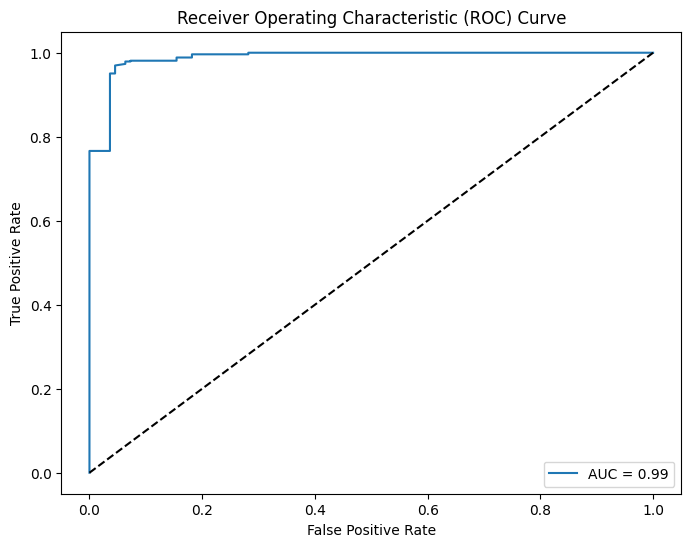

In [39]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_roc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#### Gráfico de predicciones y clasificaciones

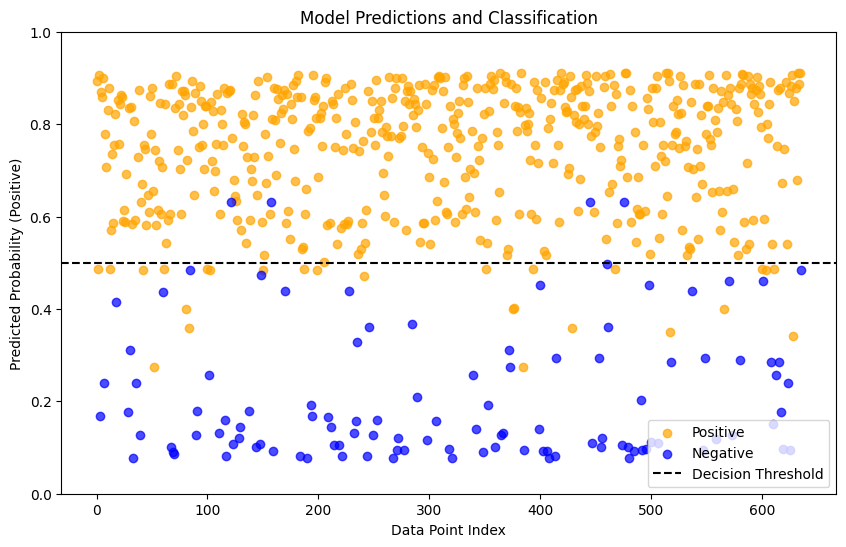

In [40]:
import matplotlib.pyplot as plt
import numpy as np


# Convertir listas a matrices NumPy
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Crear diagrama de dispersión
plt.figure(figsize=(10, 6))

# Trazar puntos positivos en naranja
plt.scatter(np.arange(len(all_labels))[all_labels == 1],
            all_probs[all_labels == 1],
            color='orange', label='Positive', alpha=0.7)

# Trazar puntos negativos en azul
plt.scatter(np.arange(len(all_labels))[all_labels == 0],
            all_probs[all_labels == 0],
            color='blue', label='Negative', alpha=0.7)

# Agregue una línea horizontal en el umbral de decisión (0,5)
plt.axhline(y=0.5, color='black', linestyle='--', label='Decision Threshold')

plt.xlabel('Data Point Index')
plt.ylabel('Predicted Probability (Positive)')
plt.title('Model Predictions and Classification')
plt.legend(loc='best')

plt.ylim(0, 1)

plt.show()

#### Curva de clasificación

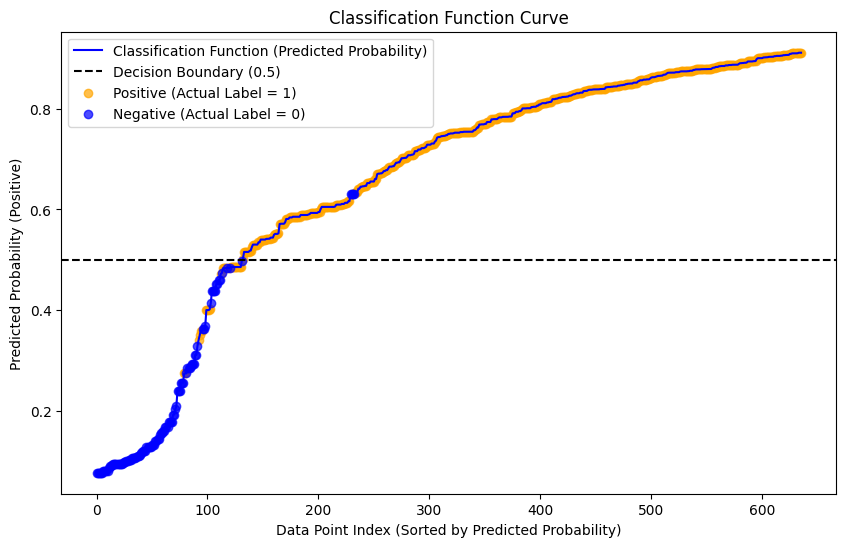

In [41]:
import matplotlib.pyplot as plt
import numpy as np


# Ordenar puntos de datos según la probabilidad prevista
sorted_indices = np.argsort(all_probs)
all_probs_sorted = np.array(all_probs)[sorted_indices]
all_labels_sorted = np.array(all_labels)[sorted_indices]

# Crear valores del eje x (índice de punto de datos)
x_values = np.arange(len(all_probs_sorted))


# Trazar la curva de la función de clasificación (probabilidades previstas)
plt.figure(figsize=(10, 6))
plt.plot(x_values, all_probs_sorted, color='blue', label='Classification Function (Predicted Probability)')


# Resaltar el límite de decisión (probabilidad de 0,5)
plt.axhline(y=0.5, color='black', linestyle='--', label='Decision Boundary (0.5)')

# Agregar puntos de dispersión para etiquetas reales
plt.scatter(x_values[all_labels_sorted == 1], all_probs_sorted[all_labels_sorted == 1], color='orange', label='Positive (Actual Label = 1)', alpha=0.7)
plt.scatter(x_values[all_labels_sorted == 0], all_probs_sorted[all_labels_sorted == 0], color='blue', label='Negative (Actual Label = 0)', alpha=0.7)

plt.xlabel('Data Point Index (Sorted by Predicted Probability)')
plt.ylabel('Predicted Probability (Positive)')
plt.title('Classification Function Curve')
plt.legend(loc='best')
plt.show()

#### Figuras de pérdidas y precisiones en Train y Validation

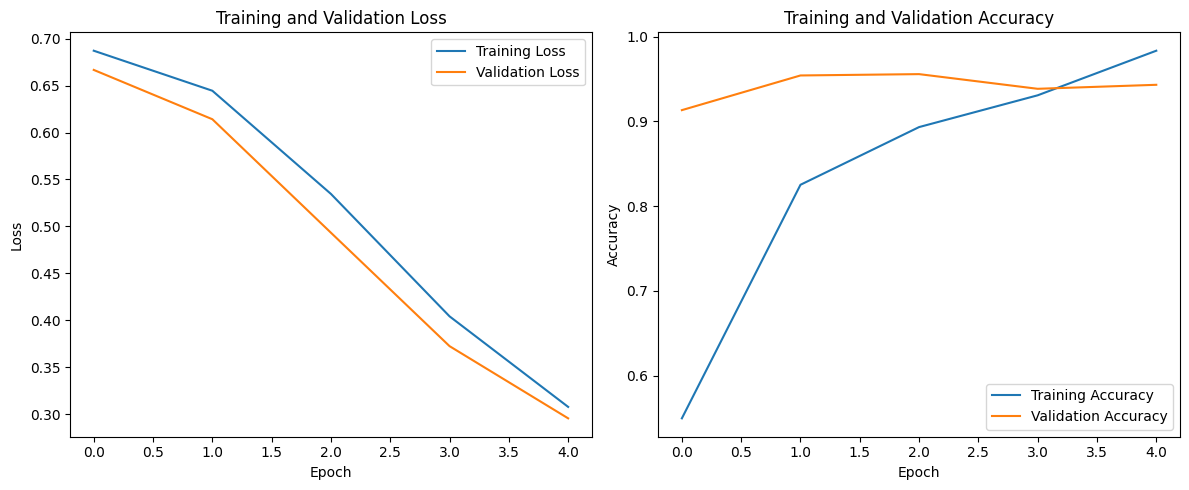

Test Accuracy: 0.9528


In [42]:
import matplotlib.pyplot as plt

# Dibujar pérdida
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Dinujar precisión
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Print test accuracy
print(f"Test Accuracy: {accuracy:.4f}")

Obviamente con 10 épocas el modelo tiene overfitting, por lo cual el número óptimo de épocas, segun se puede observar en las figuras anteriores, son 3, con lo que las métricas serán más realistas y no caeran en sobre ajuste de los datos de entranamiento.

#### Análisis modelo LSTM

Los datos indican un rendimiento excepcional del modelo en la tarea de clasificación.

**Matriz de Confusión:**

|                  | Predicho Negativo | Predicho Positivo |
|------------------|-------------------|-------------------|
| Real Negativo    | 106               | 4                |
| Real Positivo    | 26                 | 500               |

**Métricas:**

* **Accuracy (Exactitud):** 0.9528 - Porcentaje total de predicciones correctas.
* **Precision (Precisión):** 0.9921 - De las predicciones positivas, el porcentaje que fue realmente positivo.
* **Recall (Sensibilidad):** 0.9506 - De los casos realmente positivos, el porcentaje que fue correctamente identificado.
* **Specificity (Especificidad):** 0.9636 - De los casos realmente negativos, el porcentaje que fue correctamente identificado.
* **F1 Score:** 0.9709 - Media armónica entre precisión y recall, buscando un equilibrio.
* **Mean Squared Error (Error Cuadrático Medio):** 0.0472 - Promedio de los errores al cuadrado.
* **AUC-ROC (Área bajo la curva ROC):** 0.9881 - Capacidad del modelo para discriminar entre clases.

**Conclusión:**

El modelo tiene un rendimiento excepcional en todas las métricas, con alta capacidad para identificar correctamente instancias positivas y negativas.  Esto sugiere un modelo bien entrenado y generalizado, pero es importante evaluar su robustez con datos nuevos.



## Modelo LogisticRegression

### Entrenamiento del modelo LogisticRegression

In [44]:
#import pandas as pd
#from sklearn.model_selection import train_test_split, StratifiedKFold
#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, roc_curve
#import matplotlib.pyplot as plt
#from imblearn.over_sampling import SMOTE
#import nltk
#import string
#from nltk.corpus import stopwords

# Descargar recursos NLTK si es necesario
nltk.download('punkt')
nltk.download('stopwords')

# 1. Cargar y preparar datos
X = df['reviewText'].fillna('')
y = df['overall'].apply(lambda x: 1 if x >= 4 else 0)

# 2. Dividir los datos en conjuntos de entrenamiento/validación/prueba
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

#Preprocesar datos de texto:
X_train = X_train.apply(clean_text)
X_val = X_val.apply(clean_text)
X_test = X_test.apply(clean_text)

# 3. Crea una representación de bolsa de palabras
vectorizer = CountVectorizer(max_features=5000)
X_train_bow = vectorizer.fit_transform(X_train) # Vectorize training data first

# 4. Abordar el desequilibrio de datos utilizando SMOTE (sobremuestreo)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_bow, y_train)

# 5. Transformar datos de validación y prueba
X_val_bow = vectorizer.transform(X_val)
X_test_bow = vectorizer.transform(X_test)

# 6. Entrenar y evaluar con validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
for fold, (train_index, val_index) in enumerate(cv.split(X_train_resampled, y_train_resampled)):
    X_train_fold, X_val_fold = X_train_resampled[train_index], X_train_resampled[val_index]
    y_train_fold, y_val_fold = y_train_resampled[train_index], y_train_resampled[val_index]

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_fold, y_train_fold)

    y_pred_fold = model.predict(X_val_fold)
    accuracy_fold = accuracy_score(y_val_fold, y_pred_fold)
    print(f"Fold {fold + 1} Accuracy: {accuracy_fold:.4f}")

# 7. Entrenar el modelo final en los datos de entrenamiento completos y evaluar en el conjunto de validación
model = LogisticRegression(max_iter=1000)
model.fit(X_train_resampled, y_train_resampled)

y_pred_val = model.predict(X_val_bow)
accuracy_val = accuracy_score(y_val, y_pred_val)
roc_auc_val = roc_auc_score(y_val, y_pred_val)
f1_val = f1_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)

print(f"Validation Accuracy: {accuracy_val:.4f}")
print(f"Validation ROC AUC: {roc_auc_val:.4f}")
print(f"Validation F1-score: {f1_val:.4f}")
print(f"Validation Precision: {precision_val:.4f}")
print(f"Validation Recall: {recall_val:.4f}")


# 8. Evaluar en el conjunto de prueba (solo una vez al final)
y_pred_test = model.predict(X_test_bow)
accuracy_test = accuracy_score(y_test, y_pred_test)
roc_auc_test = roc_auc_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)

print(f"Test Accuracy: {accuracy_test:.4f}")
print(f"Test ROC AUC: {roc_auc_test:.4f}")
print(f"Test F1-score: {f1_test:.4f}")
print(f"Test Precision: {precision_test:.4f}")
print(f"Test Recall: {recall_test:.4f}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fold 1 Accuracy: 0.9825
Fold 2 Accuracy: 0.9778
Fold 3 Accuracy: 0.9794
Fold 4 Accuracy: 0.9650
Fold 5 Accuracy: 0.9714
Validation Accuracy: 0.9827
Validation ROC AUC: 0.9859
Validation F1-score: 0.9895
Validation Precision: 0.9981
Validation Recall: 0.9810
Test Accuracy: 0.9780
Test ROC AUC: 0.9720
Test F1-score: 0.9867
Test Precision: 0.9923
Test Recall: 0.9811


### Análisis del modelo LogisticRegression

#### Matrtiz de confusion

In [45]:
#from sklearn.metrics import confusion_matrix
#import pandas as pd

# Genera la matriz de confusión
cm = confusion_matrix(y_test, y_pred_test)

# Crea un DataFrame de Pandas para la matriz de confusión
cm_df = pd.DataFrame(cm,
                     index=['Real Negativo', 'Real Positivo'],
                     columns=['Predicho Negativo', 'Predicho Positivo'])

# Muestra la matriz de confusión en forma tabular
print(cm_df)

               Predicho Negativo  Predicho Positivo
Real Negativo                104                  4
Real Positivo                 10                518


#### Curva ROC-AUC

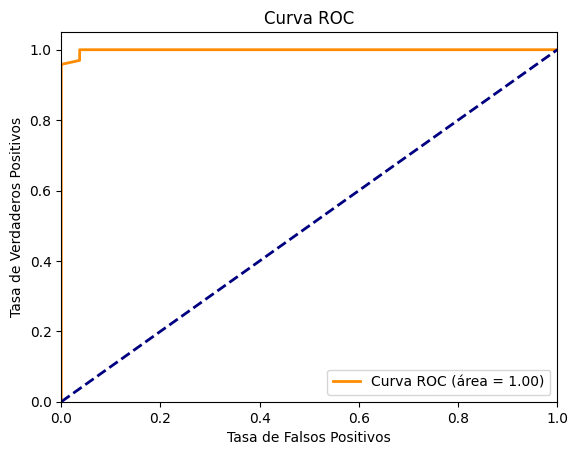

In [46]:
#from sklearn.metrics import roc_curve, auc  # Asegúrate de importar 'auc'
#import matplotlib.pyplot as plt

# Obtén las probabilidades predichas para la clase positiva en el conjunto de prueba
y_pred_proba = model.predict_proba(X_test_bow)[:, 1]

# Calcula la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Dibuja la gráfica ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

#### Preciones Folds, Validation y Test

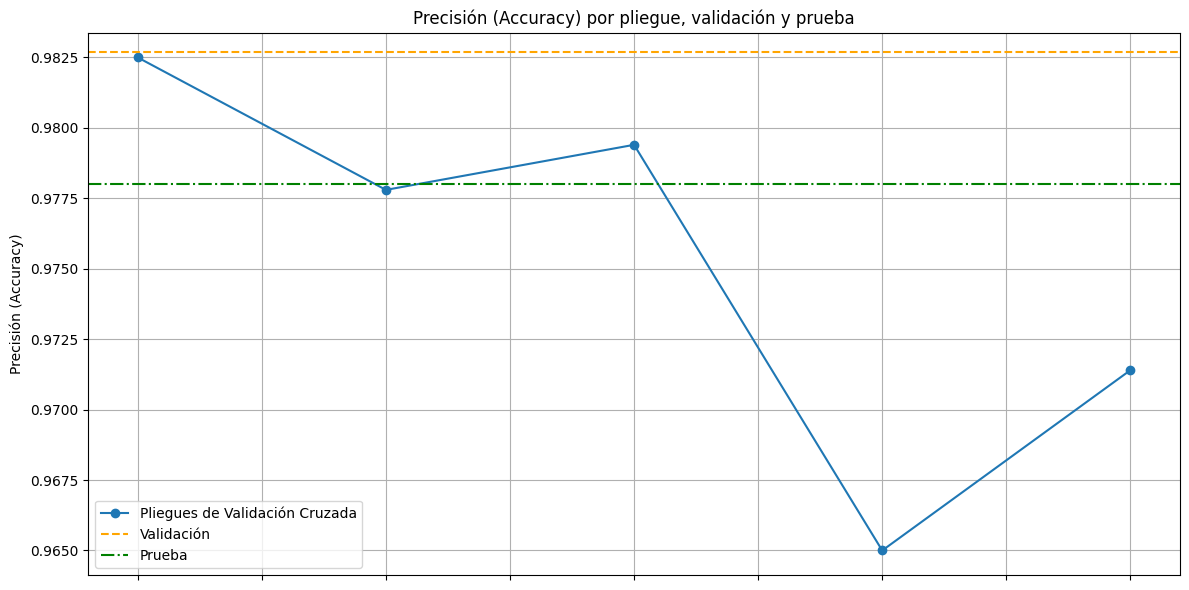

In [47]:
#import matplotlib.pyplot as plt
#import numpy as np

# Datos
accuracy_folds = [0.9825, 0.9778, 0.9794, 0.9650, 0.9714]
accuracy_validation = 0.9827  # Valor de precisión para validación
accuracy_test = 0.9780  # Valor de precisión para prueba


fig, ax = plt.subplots(figsize=(12, 6))


ax.plot(accuracy_folds, marker='o', label='Pliegues de Validación Cruzada')


ax.axhline(y=accuracy_validation, color='orange', linestyle='--', label='Validación')
ax.axhline(y=accuracy_test, color='green', linestyle='-.', label='Prueba')


ax.set_ylabel('Precisión (Accuracy)')
ax.set_title('Precisión (Accuracy) por pliegue, validación y prueba')
ax.legend()
ax.grid(True)

ax.set_xticklabels([])
fig.tight_layout()
plt.show()

#### Gráfico de coeficientes

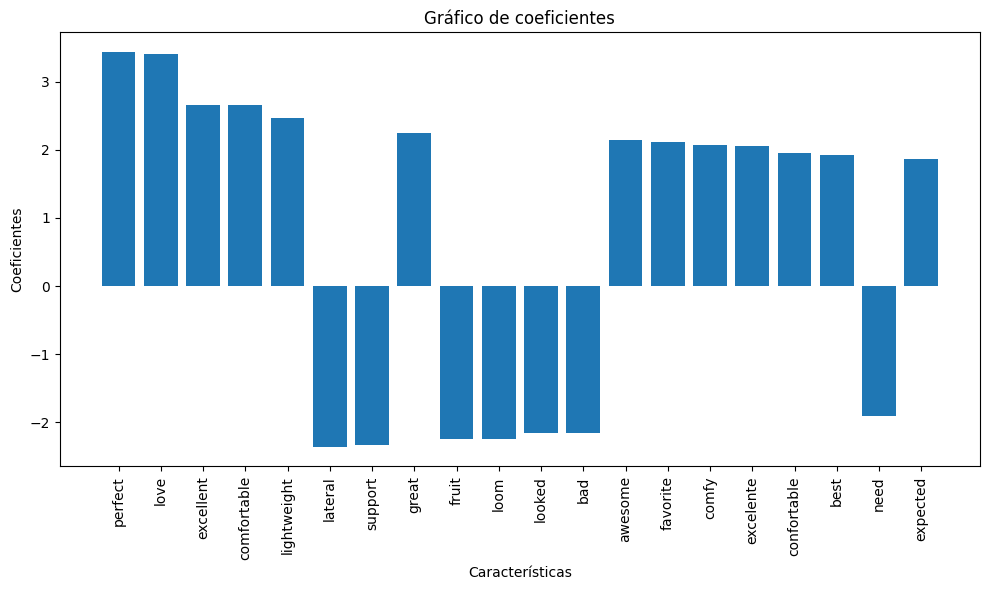

In [48]:
#import matplotlib.pyplot as plt
#import numpy as np

# Obtención nombres de las características y los coeficientes
feature_names = vectorizer.get_feature_names_out()  # Obtén los nombres de las características
coefficients = model.coef_[0]  # Obtén los coeficientes

# Ordena los coeficientes por magnitud
sorted_indices = np.argsort(np.abs(coefficients))[::-1]  # Ordena por valor absoluto
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_coefficients = [coefficients[i] for i in sorted_indices]


plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names[:20], sorted_coefficients[:20])  # Muestra los 20 principales
plt.xticks(rotation=90)
plt.xlabel('Características')
plt.ylabel('Coeficientes')
plt.title('Gráfico de coeficientes')
plt.tight_layout()
plt.show()

#### Histograma de probabilidades predichas

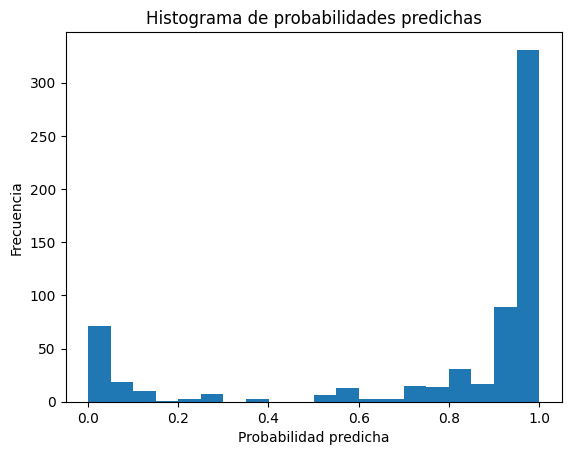

In [49]:
#import matplotlib.pyplot as plt

plt.hist(y_pred_proba, bins=20)
plt.xlabel('Probabilidad predicha')
plt.ylabel('Frecuencia')
plt.title('Histograma de probabilidades predichas')
plt.show()

#### Análisis del modelo LogisticRegression



A continuación, se presenta un análisis de las métricas obtenidas durante la validación cruzada, la validación y la prueba del modelo de Regresión Logística:

**Precisión (Accuracy) de los pliegues de validación cruzada:**

| Pliegue | Precisión |
|---|---|
| Fold 1 | 0.9825 |
| Fold 2 | 0.9778 |
| Fold 3 | 0.9794 |
| Fold 4 | 0.9650 |
| Fold 5 | 0.9714 |

**Observación:** Las precisiones de los pliegues son consistentemente altas, oscilando entre 0.9650 y 0.9825. Esto sugiere que el modelo tiene un buen rendimiento general en diferentes subconjuntos de datos de entrenamiento. La variabilidad en las precisiones entre los pliegues es relativamente baja, lo que indica que el modelo es estable y no está sobreajustado a un pliegue específico.

**Métricas de validación:**

| Métrica | Valor |
|---|---|
| Precisión (Accuracy) | 0.9827 |
| AUC ROC | 0.9859 |
| F1-score | 0.9895 |
| Precisión | 0.9981 |
| Recall | 0.9810 |

**Observación:** Las métricas de validación son excelentes, con una precisión muy alta (0.9827) y un AUC ROC cercano a 1 (0.9859), lo que indica una gran capacidad del modelo para discriminar entre las clases. El F1-score, la precisión y el recall también son muy altos, lo que confirma el buen rendimiento del modelo en la clasificación.

**Métricas de prueba:**

| Métrica | Valor |
|---|---|
| Precisión (Accuracy) | 0.9780 |
| AUC ROC | 0.9720 |
| F1-score | 0.9867 |
| Precisión | 0.9923 |
| Recall | 0.9811 |

**Observación:** Las métricas de prueba son ligeramente inferiores a las de validación, pero siguen siendo muy buenas. La precisión (0.9780) y el AUC ROC (0.9720) son altos, lo que indica que el modelo generaliza bien a datos no vistos durante el entrenamiento. El F1-score, la precisión y el recall también son altos, lo que confirma el buen rendimiento del modelo en la clasificación de nuevos datos.

**Conclusión general:**

El modelo de Regresión Logística muestra un excelente rendimiento en la clasificación, con métricas consistentemente altas en la validación cruzada, la validación y la prueba. La baja variabilidad en las precisiones de los pliegues sugiere que el modelo es estable y no está sobreajustado. Las métricas de validación y prueba indican que el modelo generaliza bien a datos no vistos durante el entrenamiento. En general, este modelo es una buena opción para la tarea de clasificación en este conjunto de datos.
